<a href="https://colab.research.google.com/github/VincentChong123/1sutd-stats-team5-prj/blob/main/Team_5_Project_(JH)_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEAM 5 - DATA VALIDATION AND STATISTICAL ANALYSIS PROJECT

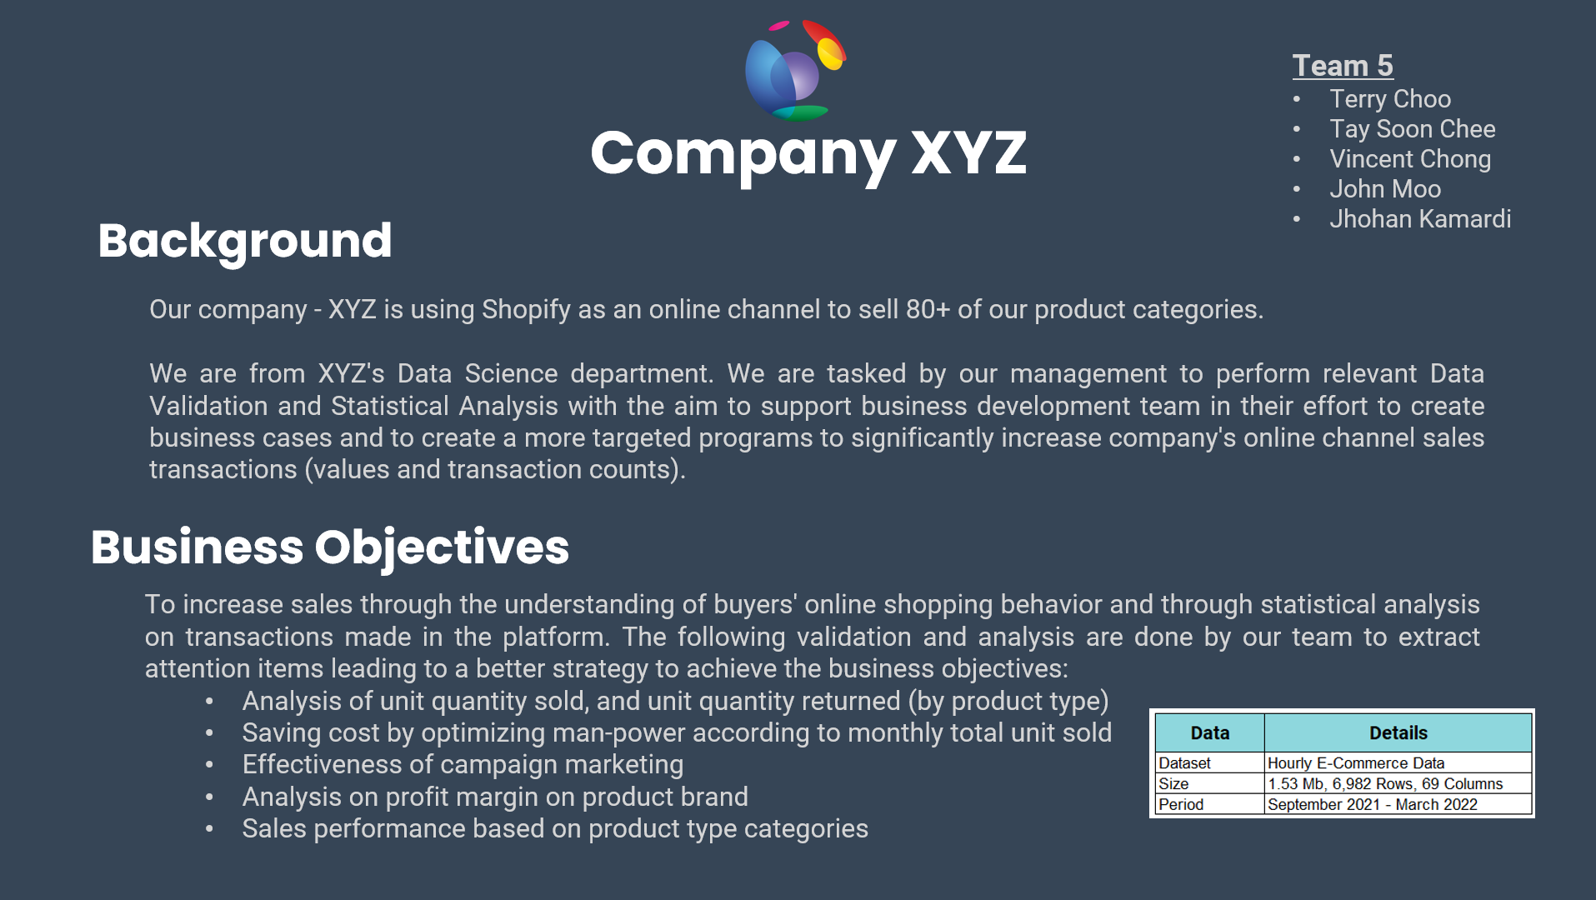

# Common code

In [292]:
IS_RUNNING_GOOGLE_COLAB = True
#IS_RUNNING_GOOGLE_COLAB = False

csv_pathname = "../dataset/" + "Ecommerce - Hour Data.csv"
sum_pathname = "../dataset/" + "Ecommerce - Hour Data-sum-day.csv"

if IS_RUNNING_GOOGLE_COLAB:  
  zip_pathname = "../dataset/" +  "Ecommerce - Hour Data.zip"


In [293]:
# import libarry
import os
import time
import pytz
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
import statsmodels.stats.weightstats as weightstats
import statsmodels.stats.proportion as proportion
import statsmodels.stats.multicomp as multi

import seaborn as sns

from statsmodels.stats.diagnostic import normal_ad
import statsmodels.api as sm

from sklearn.preprocessing import QuantileTransformer
from scipy.special import factorial


In [294]:
# timing information for checking errors
dt.timezone(offset=dt.timedelta(hours=+8))
print("-"*20)
starttime = dt.datetime.now(pytz.timezone('Singapore'))
print(f"START time {str(starttime).split('.')[0]}")
print(f"\tcheck END time at the final cell output \n\tto confirm the notebook is successfully executed till the end")

--------------------
START time 2022-05-25 20:18:02
	check END time at the final cell output 
	to confirm the notebook is successfully executed till the end


## Common utility functions

Here are the reusable utitlity functions

In [295]:
# mout google drive
import time
if IS_RUNNING_GOOGLE_COLAB:
  from google.colab import drive
  import zipfile
  drive.mount('/content/drive')
  project_dir = "/content/drive/.shortcut-targets-by-id/1hq1js1i_5vtP8Ib96QdKM31o5JrADOez/sutd-team5-prj/" #don't change    
  src_dir = project_dir + "src/"
  os.chdir(src_dir)
  assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname} in Google drive")    

print(f"current working directory is \n\t{os.getcwd()}")


def get_df_from_protected_zipfile(zip_pathname, password='VNjAMFv268"(*C*y'):

  assert(os.path.exists(zip_pathname)), print(f"can't find {zip_pathname}")

  # file = zipfile.ZipFile(zip_pathname)
  # file.setpassword(pwd = bytes('VNjAMFv268"(*C*y', 'utf-8' ))  

  with zipfile.ZipFile(zip_pathname) as file:
    try: 
      file.extractall(pwd=bytes(password, 'utf-8' ), path=os.path.dirname(zip_pathname))
    except:    
      assert False, print(f"fail to unzip {zip_pathname}")

  csv_pathname = zip_pathname[:-4]+'.csv'  
  assert os.path.exists(csv_pathname), print(f"can't find {csv_pathname}")
  try:
    df =pd.read_csv(csv_pathname)  
    print(f"read {csv_pathname}")
  except:
    print(f"can't read {csv_pathname}")

  os.remove(csv_pathname)
  print(f"removed {csv_pathname}")      

  return df

# assert(os.path.exists(zip_pathname)), print(f"can't find {zip_pathname}")
# file = zipfile.ZipFile(zip_pathname)
# file.setpassword(pwd = bytes('VNjAMFv268"(*C*y', 'utf-8' ))
# print(file.infolist)
# # file.setpassword(pwd = bytes(password, 'utf-8' ))  
# print(f"unzipping {zip_pathname}")
# file.extractall()

# utility functions
# Hypothesis test on non-probability based sampling
def get_df_sum_by_date(df:pd.DataFrame,
                         column_date:str, 
                         column_aggregate=[], 
                         freq='D',
                         is_plot=True,
                         #kind="bar"
                         ):
    """_summary_
    Aggregate columns in input dataframe by summing values given in "column_aggregate",
    according to frequency given for column_date
    
    :param df: _description_
    :type df: pd.DataFrame
    :param column_date: name of the column that stores date
    :type column_date: str
    :param column_aggregate: _description_, defaults to []
    :type column_aggregate: list, list of column name for the column to be stored
    :param freq: _description_, defaults to 'D'
    :type freq: str, default sum by day
    :param is_plot: _description_, defaults to True
    :type is_plot: bool, optional
    :return: _description_
    :rtype: _type_
    """
    
    df[f"{column_date}"] = pd.to_datetime(df[f"{column_date}"])    
    # df.rename(columns={column_date:"yyyy-mm-dd"})
    df.set_index(column_date, inplace=True)
    df_sum = df[column_aggregate].resample(rule=freq).sum()
    df_sum["aggregate_per_row"] = df_sum.aggregate("sum", axis=1)
    
    if(is_plot):
        df_sum.plot(
            # kind=kind,
            subplots=True, grid=True, figsize=(10, len(column_aggregate)))
        plt.show() 
    
    df.reset_index(inplace=True)
    df_sum.reset_index(inplace=True)
    
    return df_sum

def plot_qqplot(df_series, title, ax):
    fontsize = 14
    sm.qqplot(df_series, line="s", ax=ax)
    ax.set_title(f"{title}")
    # ax.set_ylabel(fontdict={'fontsize':fontsize})
    plt.show()

def plot_hist_kde_qq(df_series, is_input_transformed=False):
    df_series_name = argname("df_series")
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.3)
    fig.set_figwidth(14)
    print(f"{df_series_name}.mean()", round(df_series.mean()))
    if is_input_transformed == False:
        print(f"np.log({df_series_name}.mean())", round(np.log(df_series.mean()), 2))
        print(f"np.log({df_series_name}.std())", round(np.log(df_series.std()), 2))
    df_series.plot.hist(title=df_series_name, ax=ax1)
    df_series.plot.kde(title=df_series_name, ax=ax1, secondary_y=True)

    plot_qqplot(df_series, df_series_name, ax=ax2)
    plt.show()


def plot_pivot(index, columns, normalize="index", figsize=(20, 20),
               ncol=1, bbox_to_anchor=(1.35, 0.3), loc='center right'):

    df_crosstab_normalized = pd.crosstab(
        index=index, columns=columns, normalize=normalize
    )
    # display(df_crosstab_normalized)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    fig.add_subplot(ax)
    df_crosstab_normalized.plot(kind="bar", stacked=True, ax=ax)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.4, box.height * 0.5])

    # Put a legend to the right of the current axis
    ax.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, ncol=ncol)
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
current working directory is 
	/content/drive/.shortcut-targets-by-id/1hq1js1i_5vtP8Ib96QdKM31o5JrADOez/sutd-team5-prj/src


# ======================================

# ANALYSIS ON 3 SAMPLE COLUMNS (PRODUCT TYPE, ORDERED ITEM QUANTITY, RETURNED ITEM QUANTITY (BY JHOHAN)

# Background

### This section focuses on the analysis and hypothesis testing on ordered item quantity (qty sold) and returned item quantity (qty returned) which are grouped by product type (category)

Data is a 7-month sample data which include all product types and its transaction details. Various hypothesis are tested to draw some conclusions where a simple data pre-processing is done (only focused on 3 columns and some data cleaning) 

# Business Motivation behind Hypothesis Testing

Decision making is a crucial part of every business. Business Development manager is planning to create a program which incentivize Product Managers whom have successfully reduce number of return orders of product categories they are in-charge to. Returned items are known due to various reasons (false product info, product defects, poor customer service etc.). Business Development manager currently believes product types / categories with top transaction counts are having the most returned item quantity hence he needs to speak to each product manager to discuss the program and execute it, but he is not sure he has enough evidence to support his assumption / hypothesis.

# PERFORMED ANALYSIS

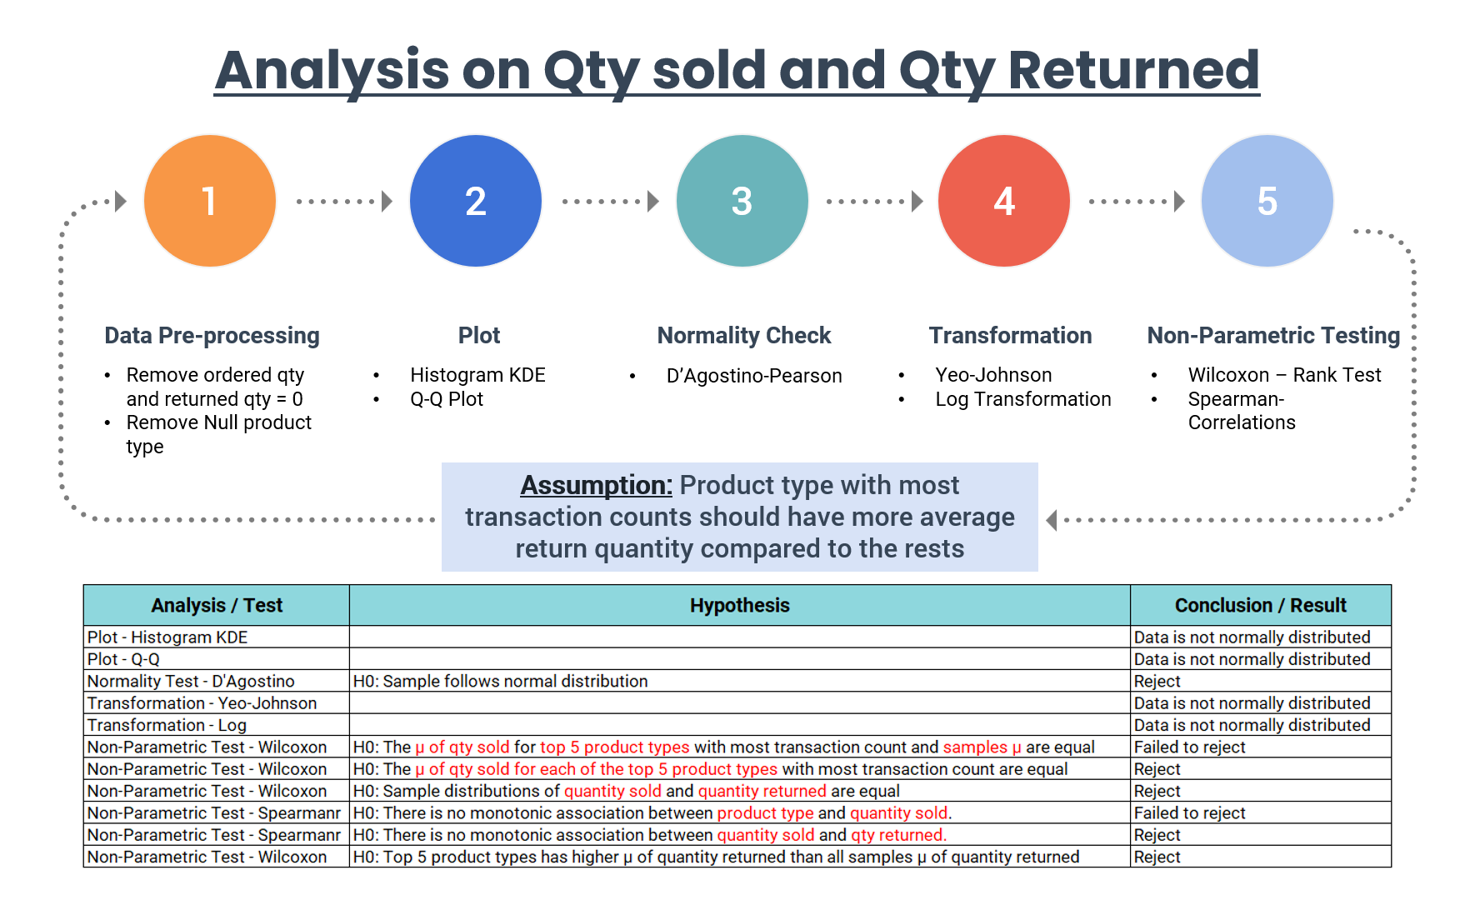

## Data Pre-processing

* Focused columns: product_type, ordered_item_quantity, returned_item_quantity
* Remove rows with zero ordered item quantity and returned item quantity
* Remove null product type

In [296]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfjh = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfjh = pd.read_csv(csv_pathname)

read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


In [297]:
alpha_value = 0.05
random_seed = 123

In [298]:
# New DataFrame only for 3 focused columns
dfjh = pd.DataFrame(dfjh[["product_type", "ordered_item_quantity", "returned_item_quantity"]])
print('Current DataFrame')
print('=================')
display(dfjh)

# Convert negative returned quantity to positive number
dfjh["returned_item_quantity"] = dfjh["returned_item_quantity"] * -1

# Remove rows with zero ordered and returned quantity
index_null = dfjh.loc[(dfjh.ordered_item_quantity==0) & (dfjh.returned_item_quantity==0)].index
print('')
print('Index with zero ordered and returned quantity (to be removed)')
print('=============================================================')
print(index_null)
dfjh = dfjh.drop(index_null)

print('')
print('DataFrame info after the removal of zero ordered and returned quantity')
print('======================================================================')

print(dfjh.info())

display(dfjh)
print('='*120)

# Remove row - null product type
dfjh = dfjh.dropna(subset = ['product_type'])


# Get statistic of sample data - product_type (count, mean, variance, standard deviation). Round to the nearest whole number.
print('')
print('Latest DataFrame Statistic Information')
print('======================================')
print(dfjh.describe())
print('='*120)

pop_count = round(dfjh.product_type.count(),5)

print ("Sample Count for Product Type = ", pop_count)
print ("Unique count for Product Type = ", len(dfjh["product_type"].unique()))
print('='*120)

Current DataFrame


,product_type,ordered_item_quantity,returned_item_quantity
0,NaN,0,0
1,NaN,0,0
2,NaN,0,0
3,NaN,0,0
4,NaN,0,0
...,...,...,...
6977,NaN,0,0
6978,NaN,0,0
6979,Blush,1,0
6980,NaN,0,0



Index with zero ordered and returned quantity (to be removed)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6980, 6981],
           dtype='int64', length=4897)

DataFrame info after the removal of zero ordered and returned quantity
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 17 to 6979
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   product_type            2084 non-null   object
 1   ordered_item_quantity   2085 non-null   int64 
 2   returned_item_quantity  2085 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 65.2+ KB
None


,product_type,ordered_item_quantity,returned_item_quantity
17,Face Moisturizer,1,0
18,Daily & Health Supplements,1,0
20,Tools,1,0
22,Daily & Health Supplements,1,0
138,Dental Care,0,1
...,...,...,...
6946,Lotion,1,0
6950,Beauty Tools,2,0
6952,Eyeshadow,1,0
6968,Mother Body Care,1,0



Latest DataFrame Statistic Information
       ordered_item_quantity  returned_item_quantity
count            2084.000000             2084.000000
mean                1.265355                0.030230
std                 0.935833                0.211407
min                 0.000000                0.000000
25%                 1.000000                0.000000
50%                 1.000000                0.000000
75%                 1.000000                0.000000
max                15.000000                5.000000
Sample Count for Product Type =  2084
Unique count for Product Type =  80


## Histogram with KDE

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


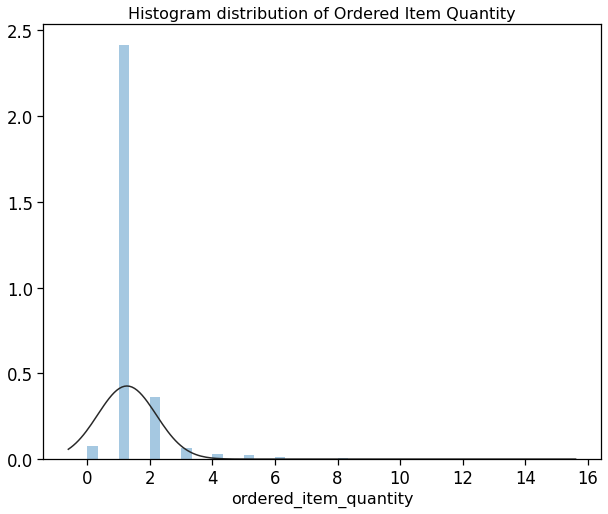

In [299]:
# Plot ordered_item_quantity to see the distribution 
plt.rcParams["figure.figsize"] = [10,8]
sns.distplot(dfjh['ordered_item_quantity'], fit=stats.norm, kde=False)
sns.set_context("notebook", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plt.title('Histogram distribution of Ordered Item Quantity')
plt.show();

## Probability Plot

### Quantile-Quantile (Q-Q) Plot

This plot is to see the sample distribution relative to the normal distribution

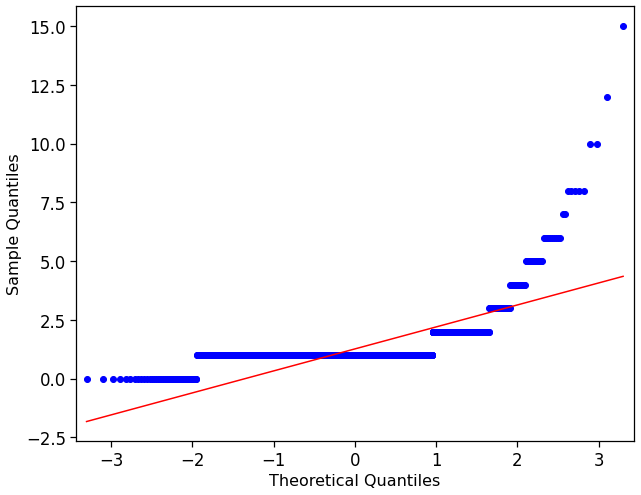

In [300]:
# Quantile-Quantile (Q-Q) Plot
import statsmodels.api as sm

x = dfjh['ordered_item_quantity']

qq = sm.qqplot(x, line='s')
plt.show()

### Conclusion

### <span style='color:blue'> Above plot shows that the sample clearly doesn’t follow the normal distribution, therefore a non-parametric test will be preferred to test the hypothesis </span>

## Normality Tests

#### D'Agostino-Pearson test

To further confirm the above conclusion, the following normality test is performed:

- D'Agostino-Pearson test

### Definition: D'Agostino-Pearson test
Calculates summary statistics from data, namely skewness and kurtosis. 
- Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
- Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

It then calculates how far each of these values differs from the value expected with a Gaussian distribution in terms of asymmetry and shape, and computes a single P value from the sum of these discrepancies.

#### Hypothesis
- Test the hypothesis that the ordered item quantity do not follow a normal distribution
    - $H_0$: Sample follow a normal distribution 
    - $H_1$: Sample do not follow a normal *distribution*

In [301]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(dfjh['ordered_item_quantity'])      

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3),"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  2328.551
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.


#### Conclusion

Sample likely not follow a normal distribution

## Transformation

### Performed below transformation if normal distribution can be achieved

* Yeo Johnson Transformation
* Log Transformation

### Yeo-Johnson transformation
- No predetermined scale
- Exactly scale to zero mean and unit variance (i.e. standard deviation to 1)
- Make changes to distribution, therefore reduce skewness and kurtosis
- Less affected to outliers by maximum likelihood estimation
- Best on non-normal data with heteroscedasticity (unequal variability issue) and when normality are desired.

In [302]:
# Define function for comparing two plots
def compare_plot(feature, transformed_feature):
    plt.rcParams["figure.figsize"] = 17,5
    fig,ax = plt.subplots(1,2)

    stdDev = np.round(np.std(feature)[0],4) # for normal distribution, standard deviation is 1
    skewness = np.round(skew(feature),4) # for normal distribution, skewness = 0
    excess_kurtosis = np.round(kurtosis(feature),4) # for normal distribution, excess kurtosis = 0
    sns.histplot(feature, kde=True, ax=ax[0], legend=False)
    ax[0].set_xlabel(feature.columns[0])
    ax[0].set_title("ORIGINAL \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(stdDev, skewness, excess_kurtosis));

    transformed_stdDev = np.round(np.std(transformed_feature)[0],4)
    transformed_skewness = np.round(skew(transformed_feature),4)
    transformed_excess_kurtosis = np.round(kurtosis(transformed_feature),4)
    sns.histplot(transformed_feature, kde=True, ax=ax[1], legend=False)
    ax[1].set_xlabel(feature.columns[0])
    ax[1].set_title("TRANSFORMED \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(transformed_stdDev, transformed_skewness, transformed_excess_kurtosis));

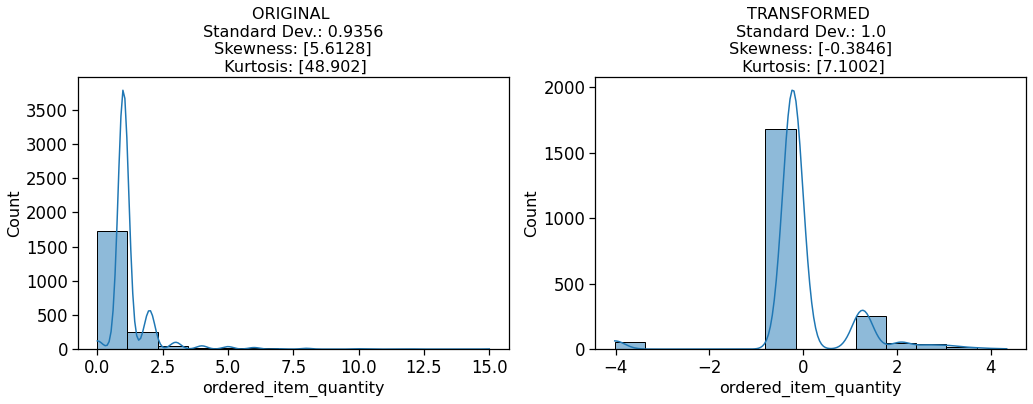

In [303]:
from sklearn.preprocessing import PowerTransformer

# Select feature
feature = dfjh[["ordered_item_quantity"]]

# Transformation
pt = PowerTransformer() 
pt.fit(feature) 
transformed_feature = pt.transform(feature) 
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

In [304]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(transformed_feature)      

print("The test statistic is: ", test_statistic)
print("The p-value is: ", p_value,"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  [351.78958007]
The p-value is:  [4.07252063e-77] 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.


### Log Transformation
- No predetermined scale
- Make changes to distribution, therefore reduce skewness and kurtosis
- Less affected by outliers due to using logarithm
- Best on non-normal data with outliers and when normality are desired. Only work on non-zero and positive data.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


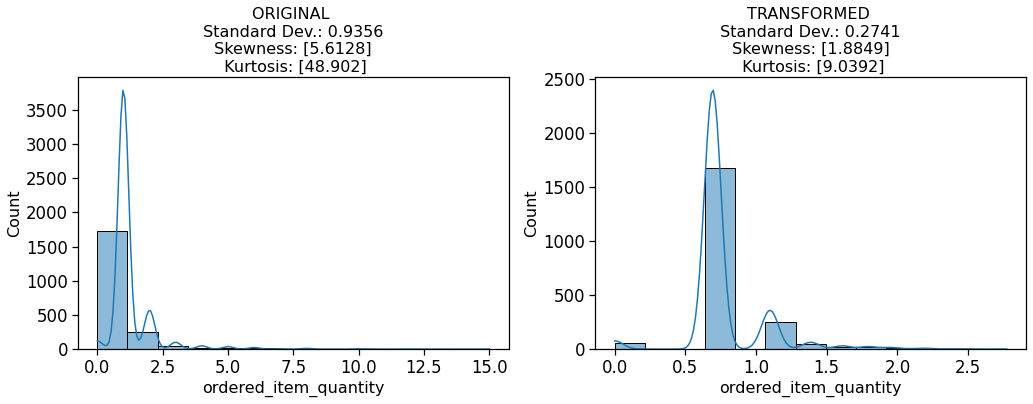

In [305]:
from sklearn.preprocessing import FunctionTransformer

# Select feature
feature = dfjh[["ordered_item_quantity"]] # in series

# Transformation
transformer = FunctionTransformer(np.log1p, validate=True)
transformed_feature = transformer.transform(feature) # no fit and can perform transform directly on both training data and test data.
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

In [306]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(transformed_feature)      

print("The test statistic is: ", test_statistic)
print("The p-value is: ", p_value,"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  [933.1052055]
The p-value is:  [2.39209878e-203] 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.


### <span style='color:blue'> Conclusion</span>

Sample data is not normally distributed hence non parametric testing

## Non Parametric Testing

### Wilcoxon Signed Rank Test

### 1) Hypothesis Testing
- Test the hypothesis on ordered item quantity that there is no difference between all sample median and the median of the product type (Top 5) with the highest transaction count
- $H_0$: The median of qty sold for top 5 product types with most transaction count and samples µ are equal
- $H_1$: The median of qty sold for top 5 product types with most transaction count and samples µ are not equal

In [307]:
dfjh_1 = pd.DataFrame(dfjh.groupby("product_type").agg(mean_ordered_qty = ("ordered_item_quantity", "mean"), trx_count = ("ordered_item_quantity", "count")))
dfjh_1 = dfjh_1.sort_values(["trx_count"], ascending=False)
print("Each product type's mean value and transaction count")
print("====================================================")
print('')
print('Facial Mask has the highest transaction count')
display(dfjh_1.head(5))
print("="*120)

# New DataFrame to store top 5 product types with most transaction count
dfjh_2 = pd.DataFrame(dfjh_1.head(5))
print(dfjh_2['mean_ordered_qty'])
print("="*120)

Each product type's mean value and transaction count

Facial Mask has the highest transaction count


,mean_ordered_qty,trx_count
product_type,,
Facial Mask,1.361991,221
Weight Management,1.602410,166
Cleanser,1.163399,153
Daily & Health Supplements,1.420635,126
Essence,1.156863,102


product_type
Facial Mask                   1.361991
Weight Management             1.602410
Cleanser                      1.163399
Daily & Health Supplements    1.420635
Essence                       1.156863
Name: mean_ordered_qty, dtype: float64


In [308]:
# By python function
#Specify the two variable that are believed to be paired
(test_statistic, p_value) = stats.wilcoxon(np.array((dfjh_2['mean_ordered_qty']))-(dfjh['ordered_item_quantity'].mean()), alternative='greater')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Samples are likely not having the same median.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Samples are likely having the same median")

The test statistic is:  10.0
The p-value is:  0.25009 

At 0.05 level of significance, we FAILED TO REJECT null hypothesis.
Conclusion: Samples are likely having the same median


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


##### Decision / Conclusion

Accept Null Hypothesis since p-value is greater than alpha.
Product types which have greater transaction count do not necessarily have more average quantity sold

### 2) Hypothesis Testing

#### Test the hypothesis that the median of ordered quantity for the top 5 product types with most transaction count are the same

- $H_0$: The median of qty sold for each of the top 5 product types with most transaction count are equal
- $H_1$: The median of qty sold for each of the top 5 product types with most transaction count are not equal

In [309]:
print(dfjh_1.head(5))

                            mean_ordered_qty  trx_count
product_type                                           
Facial Mask                         1.361991        221
Weight Management                   1.602410        166
Cleanser                            1.163399        153
Daily & Health Supplements          1.420635        126
Essence                             1.156863        102


In [310]:
# Get statistic of data of top 5 transaction counts

grp = dfjh.groupby("product_type")
print(grp["ordered_item_quantity"].describe())
print('='*120)

grpOne = dfjh.groupby("product_type").get_group("Facial Mask")
colA = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Weight Management")
colB = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Cleanser")
colC = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Daily & Health Supplements")
colD = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Essence")
colE = grpOne["ordered_item_quantity"]

                   count      mean       std  min  25%  50%  75%   max
product_type                                                          
Acne Cream           5.0  1.400000  1.140175  0.0  1.0  1.0  2.0   3.0
Air Freshener       12.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
Baby Body Care      11.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
Baby Dental Care     2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
Baby Hair Care      16.0  1.125000  0.718795  0.0  1.0  1.0  1.0   3.0
...                  ...       ...       ...  ...  ...  ...  ...   ...
Toner               33.0  1.030303  0.529437  0.0  1.0  1.0  1.0   3.0
Tools                1.0  1.000000       NaN  1.0  1.0  1.0  1.0   1.0
UV Protector        93.0  1.118280  0.568168  0.0  1.0  1.0  1.0   5.0
Weight Management  166.0  1.602410  1.687313  0.0  1.0  1.0  2.0  15.0
Whitening Cream      8.0  1.125000  0.353553  1.0  1.0  1.0  1.0   2.0

[80 rows x 8 columns]


In [311]:
# By Python function

(test_statistic, p_value) = stats.f_oneway(colA, colB, colC, colD, colE)

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis. Average quantity sold for top 5 product types are not the same")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis. Average quantity sold for top 5 product types are the same")

The test statistic is:  4.574
The p-value is:  0.001
At 0.05 level of significance, we reject null hypothesis. Average quantity sold for top 5 product types are not the same


##### Decision / Conclusion

We reject null hypothesis. Average order quantity for top 5 product types are not the same

## Another Non Parametric Testing

### 1) Wilcoxon Signed Rank Test

#### Test the hypothesis that sample distributions quantity sold and quantity returned are equal
- $H_0$: Sample distributions of quantity sold and quantity returned are equal
- $H_1$: Sample distributions of quantity sold and quantity returned are not equal

In [312]:
# Get statistic of data

colA = dfjh["ordered_item_quantity"]
print(colA.describe())
print("")

colB = dfjh["returned_item_quantity"]
print(colB.describe())

count    2084.000000
mean        1.265355
std         0.935833
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: ordered_item_quantity, dtype: float64

count    2084.000000
mean        0.030230
std         0.211407
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: returned_item_quantity, dtype: float64


In [313]:
# Specify the two variable that are believed to be paired
(test_statistic, p_value) = stats.wilcoxon(colB,colA, alternative='less')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample distributions for quantity sold and quantity returned are not equal.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample distributions for quantity sold and quantity returned are equal.")

The test statistic is:  52848.0
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample distributions for quantity sold and quantity returned are not equal.


### 2) Spearman-Correlations

#### Test the hypothesis that there is monotonic association between product type and quantity sold
- $H_0$: There is no monotonic association between product type and quantity sold.
- $H_1$: There is monotonic association between product type and quantity sold.

In [314]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(dfjh['product_type'],dfjh['ordered_item_quantity'], nan_policy="omit")

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The correlation coefficient is:  -0.02
The p-value is: 0.41412
At 0.05 level of significance, we FAILED TO REJECT null hypothesis.
Conclusion: Monotonic association likely not exist between these two variables.


#### Test the hypothesis that there is monotonic association between quantity sold and quantity returned
- $H_0$: There is no monotonic association between quantity sold and quantity returned.
- $H_1$: There is monotonic association between quantity sold and quantity returned.

In [315]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(dfjh['ordered_item_quantity'],dfjh['returned_item_quantity'], nan_policy="omit")

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The correlation coefficient is:  -0.40
The p-value is: 0.00000
At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Monotonic association likely exist between these two variables.


## Hypothesis Test on Product Manager's Assumption

### TOP 5 product types with the most transaction counts will have greater average of quantity returned compared to all sample average of quantity returned
- $H_0$: Top 5 product types has higher median of quantity returned than all samples µ of quantity returned
- $H_1$: Top 5 product types has lesser median of quantity returned than all samples µ of quantity returned

In [316]:
# Group product_type to get statistic information of each
# Get top 5 product type with most transaction counts
dfjh_3 = pd.DataFrame(dfjh.groupby("product_type").agg(trx_count = ("ordered_item_quantity", "count"), ordered_qty = ("ordered_item_quantity", "sum"), mean_ordered_qty = ("ordered_item_quantity", "mean"), returned_qty = ("returned_item_quantity", "sum"), mean_returned_qty = ("returned_item_quantity", "mean")))
dfjh_3['return_to_order_pct'] = dfjh_3['returned_qty'] / dfjh_3['ordered_qty']
dfjh_3 = dfjh_3.sort_values(["trx_count"], ascending=False)
print('All Sample Data')
print('===============')
display(dfjh_3)
print('='*120)
print('')

# New DataFrame for top 5 product types
top_5 = ['Facial Mask', 'Weight Management', 'Cleanser', 'Daily & Health Supplements', 'Essence']
#top_10 = ['Facial Mask', 'Weight Management', 'Cleanser', 'Daily & Health Supplements', 'Essence', 'Beauty Supplements', 'UV Protector', 'Body Care', 'Lotion', 'Face Moisturizer']

dfjh_4 = dfjh[dfjh['product_type'].isin(top_5)]

dfjh_4 = pd.DataFrame(dfjh_4.groupby("product_type").agg(trx_count = ("ordered_item_quantity", "count"), ordered_qty = ("ordered_item_quantity", "sum"), mean_ordered_qty = ("ordered_item_quantity", "mean"), returned_qty = ("returned_item_quantity", "sum"), mean_returned_qty = ("returned_item_quantity", "mean")))
dfjh_4['return_to_order_pct'] = dfjh_4['returned_qty'] / dfjh_3['ordered_qty']
dfjh_4 = dfjh_4.sort_values(["trx_count"], ascending=False)
print('Top 5 Product Types')
print('===================')
display(dfjh_4)

All Sample Data


,trx_count,ordered_qty,mean_ordered_qty,returned_qty,mean_returned_qty,return_to_order_pct
product_type,,,,,,
Facial Mask,221,301,1.361991,6,0.027149,0.019934
Weight Management,166,266,1.602410,2,0.012048,0.007519
Cleanser,153,178,1.163399,4,0.026144,0.022472
Daily & Health Supplements,126,179,1.420635,3,0.023810,0.016760
Essence,102,118,1.156863,2,0.019608,0.016949
...,...,...,...,...,...,...
Feeding,1,1,1.000000,0,0.000000,0.000000
Tools,1,1,1.000000,0,0.000000,0.000000
Hair Tools,1,1,1.000000,0,0.000000,0.000000



Top 5 Product Types


,trx_count,ordered_qty,mean_ordered_qty,returned_qty,mean_returned_qty,return_to_order_pct
product_type,,,,,,
Facial Mask,221,301,1.361991,6,0.027149,0.019934
Weight Management,166,266,1.602410,2,0.012048,0.007519
Cleanser,153,178,1.163399,4,0.026144,0.022472
Daily & Health Supplements,126,179,1.420635,3,0.023810,0.016760
Essence,102,118,1.156863,2,0.019608,0.016949


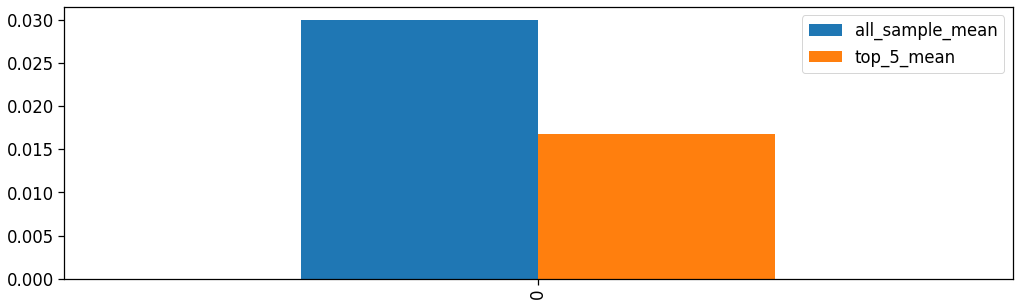

In [317]:
# New DataFrame to store mean
a = dfjh_3['return_to_order_pct'].mean()
b = dfjh_4['return_to_order_pct'].mean()

x = {'all_sample_mean': [a], 'top_5_mean': [b]}
dfjh_5 = pd.DataFrame(data=x)

# Barchart to show comparison
import matplotlib.pyplot as plt
dfjh_5.plot(y=["all_sample_mean", "top_5_mean"], kind="bar")

Result: Above chart shows the mean of returned item quantity of top 5 product types is actually lower than all sample mean. Despite this obvious difference between the two means, we cannot conclude that they are significantly different, until a test of hypothesis confirms it 

In [318]:
# Perform Hypothesis Testing
#Specify the two variable that are believed to be paired
(test_statistic, p_value) = stats.wilcoxon(np.array((dfjh_4['return_to_order_pct']))-(dfjh_3['return_to_order_pct'].mean()), alternative='less')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Top 5 product types with most transaction count DO NOT have greater percentage of quantity returned")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Top 5 product types with most transaction count have greater percentage of quantity returned")

The test statistic is:  0.0
The p-value is:  0.02156 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Top 5 product types with most transaction count DO NOT have greater percentage of quantity returned


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Conclusion

In [319]:
print('')
print('Conclusion:')
print('===========')
print('')
print('Business Development Manager should talk about the incentive program to Product Managers who are in-charge for the below product types instead')
print('')
print('')
display(dfjh_3.sort_values(["return_to_order_pct"], ascending=False).head())


Conclusion:

Business Development Manager should talk about the incentive program to Product Managers who are in-charge for the below product types instead




,trx_count,ordered_qty,mean_ordered_qty,returned_qty,mean_returned_qty,return_to_order_pct
product_type,,,,,,
Insecticide,5,3,0.600000,2,0.400000,0.666667
Gift Set/Box,8,6,0.750000,2,0.250000,0.333333
Acne Cream,5,7,1.400000,2,0.400000,0.285714
Gift Sets,16,13,0.812500,3,0.187500,0.230769
Body Care,84,83,0.988095,12,0.142857,0.144578


# Saving cost by optimizing man-power according to monthly total unit sold

## Busines question
Fast online order fulfillment speed is critical to attract online customers.
Therefore, the company plans to increase working hours for a part-timer staff who handles the fulfilment.

However, this will reduce our profit margin. Therefore, the management requests a justification from a statistical point of view using the past 6 month sales data.

The data analyst estimated probability of daily number of unit sold for months with peak and non-peak sales. 


## Proprocessing

In [320]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfvc = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfvc = pd.read_csv(csv_pathname)

dfvc.hour = pd.to_datetime(dfvc.hour)
display(dfvc.head(2))
 

read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


,hour,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,...,gross_profit,gross_margin,units_per_transaction,customers,pending_sales,net_quantity,ordered_item_quantity,average_units_ordered,returned_item_quantity,percent_of_sales_with_staff_help
0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
1,2021-09-01 01:00:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0


### Only keep product with sale transaction 
We remove rows for non-sales such as returning a product and shipping


In [321]:
df = dfvc
size_before = df.shape[0]
df = df[df.financial_status =="paid"]
df = df[df.sale_line_type=="product"]
print(f"Before removing {size_before} rows,\nAfter removing {df.shape[0]} rows ")


Before removing 6982 rows,
After removing 1957 rows 


### Timestamp processing

In [322]:
df.hour = pd.to_datetime(df.hour)
df.set_index("hour", inplace=True)

In [323]:
df_1hot = pd.get_dummies(df.product_type)
display(df_1hot.head(2))
df_concat = pd.concat([df, df_1hot], axis=1).head()
display(df_concat.head(2))

,Acne Cream,Air Freshener,Baby Body Care,Baby Dental Care,Baby Hair Care,Beauty Supplements,Beauty Tools,Beverage,Blush,Body Care,...,Shampoo,Socks,Stain Remover,Sun Care,Supplements,Toner,Tools,UV Protector,Weight Management,Whitening Cream
hour,,,,,,,,,,,,,,,,,,,,,
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,cost_tracked,...,Shampoo,Socks,Stain Remover,Sun Care,Supplements,Toner,Tools,UV Protector,Weight Management,Whitening Cream
hour,,,,,,,,,,,,,,,,,,,,,
2021-09-01 17:00:00,No,No,paid,fulfilled,3.950000e+12,#1015,One-time,order,product,Yes,...,0,0,0,0,0,0,0,0,0,0
2021-09-01 17:00:00,No,No,paid,fulfilled,3.950000e+12,#1014,One-time,order,product,Yes,...,0,0,0,0,0,0,0,0,0,0


## Time series data *exploration*

Fulfillment depends on number of unit sold and shipment address, regardless of product price. Therefore, first we analyze number of unit sold and to analyze number of shipment in future. 



### Trends for unit sold per day for the  popular products

We focus on the top 20 popular product types that cover 80% of total unit sold between 2021 Sept to 2022 March.

Top 20 products that covers 78% of total unit sold
product_type_topN, Index(['Facial Mask', 'Weight Management', 'Cleanser',
       'Daily & Health Supplements', 'Essence', 'Beauty Supplements',
       'UV Protector', 'Lotion', 'Body Care', 'Face Moisturizer', 'Serum',
       'Eye Mask', 'Dental Care', 'Shampoo', 'Beauty Tools', 'Emulsion',
       'Makeup Remover', 'Hair Treatment', 'Eye Cream', 'Concealers'],
      dtype='object')


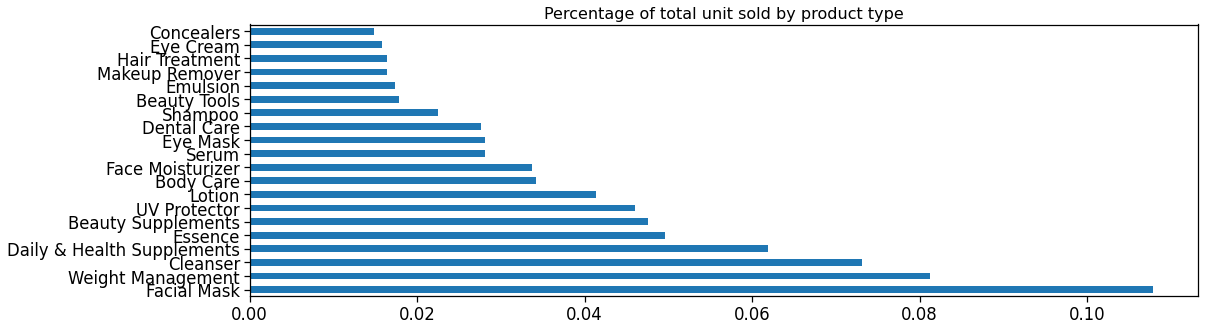

In [324]:
topN = 20
df.product_type.value_counts(normalize=True)[:topN].plot(kind="barh", title="Percentage of total unit sold by product type")
sum_topN = df.product_type.value_counts(normalize=True)[:topN].values.sum()
print(f"Top {topN} products that covers {int(100*sum_topN)}% of total unit sold")
product_type_topN = df.product_type.value_counts(normalize=True)[:topN].keys()
print(f"product_type_topN, {product_type_topN}")


In [325]:
df_1hot = pd.get_dummies(df.product_type)
display(df_1hot.head())

,Acne Cream,Air Freshener,Baby Body Care,Baby Dental Care,Baby Hair Care,Beauty Supplements,Beauty Tools,Beverage,Blush,Body Care,...,Shampoo,Socks,Stain Remover,Sun Care,Supplements,Toner,Tools,UV Protector,Weight Management,Whitening Cream
hour,,,,,,,,,,,,,,,,,,,,,
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-06 13:00:00,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [326]:
# print("hour" in df_1hot.columns)
df_1hot.reset_index(inplace=True)
display(df_1hot.head(3))

,hour,Acne Cream,Air Freshener,Baby Body Care,Baby Dental Care,Baby Hair Care,Beauty Supplements,Beauty Tools,Beverage,Blush,...,Shampoo,Socks,Stain Remover,Sun Care,Supplements,Toner,Tools,UV Protector,Weight Management,Whitening Cream
0,2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-01 17:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Visualization of daily number of unit sold 

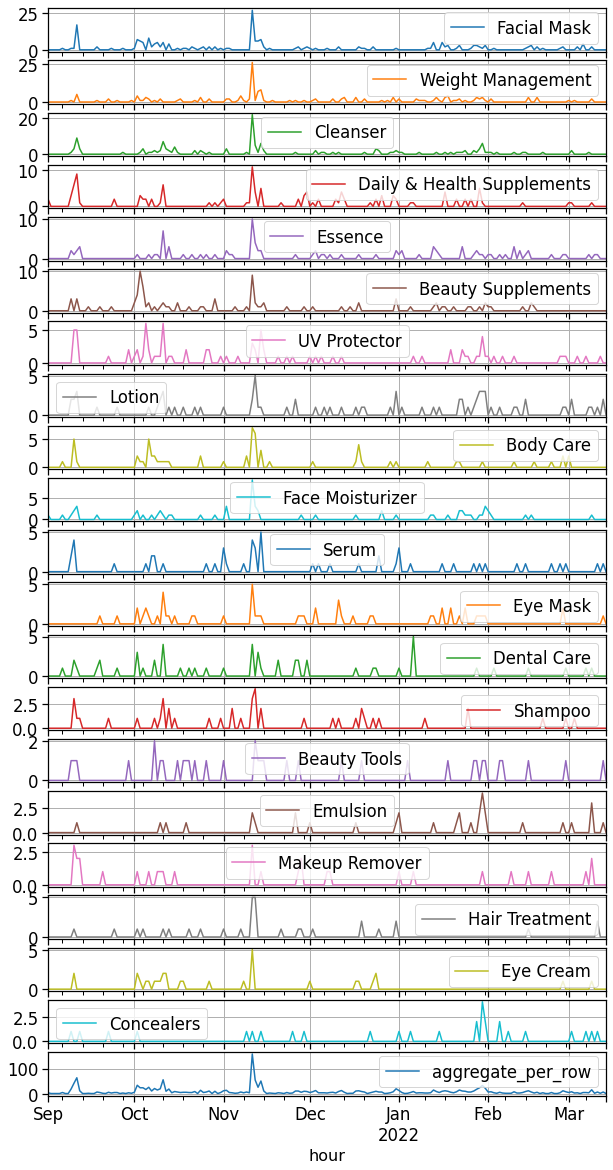

In [327]:
df_day1 = get_df_sum_by_date(
    df_1hot,
    column_date="hour", 
    column_aggregate=list(df.product_type.value_counts(ascending=False).keys())[:topN], 
    freq='D',
    is_plot=True,
)


In [328]:
display(df_day1.head())

,hour,Facial Mask,Weight Management,Cleanser,Daily & Health Supplements,Essence,Beauty Supplements,UV Protector,Lotion,Body Care,...,Eye Mask,Dental Care,Shampoo,Beauty Tools,Emulsion,Makeup Remover,Hair Treatment,Eye Cream,Concealers,aggregate_per_row
0,2021-09-01,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,2021-09-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-09-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-09-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Probability plot for the count of unit sold daily

Since the average count of total unit sold daily is less than 20 for non-peak months, 
we use Poisson distribution to estimate probability. 

For Poisson distribution, the formula of probability for occurance for ${x}$ number of unit count, in a data with mean value ${lambda}$  is shown below

$P\left( x \right) = \frac{{e^{ - \lambda } \lambda ^x }}{{x!}}$

We transform the daily unit order into 2 times of its square root, instead of typical log transform because our count data include zero value. 2 times of square root is to make variance close to mean value, as required by Poisson distribution.

In [329]:
def plot_poisson(lambda_mean, x, is_show=True, xlab="", ylab=""):
    p = np.exp(-lambda_mean)*np.power(lambda_mean, x)/(factorial(x))
    # plt.xlabel(xlab)
    # plt.ylabel(ylab)
    plt.plot(x, p, 'bs')
    # y = poisson.pmf(x, mu=lambda_mean, loc=0)
    # plt.scatter(x, y)
    if is_show:
        plt.show()   

aggregate_per_row


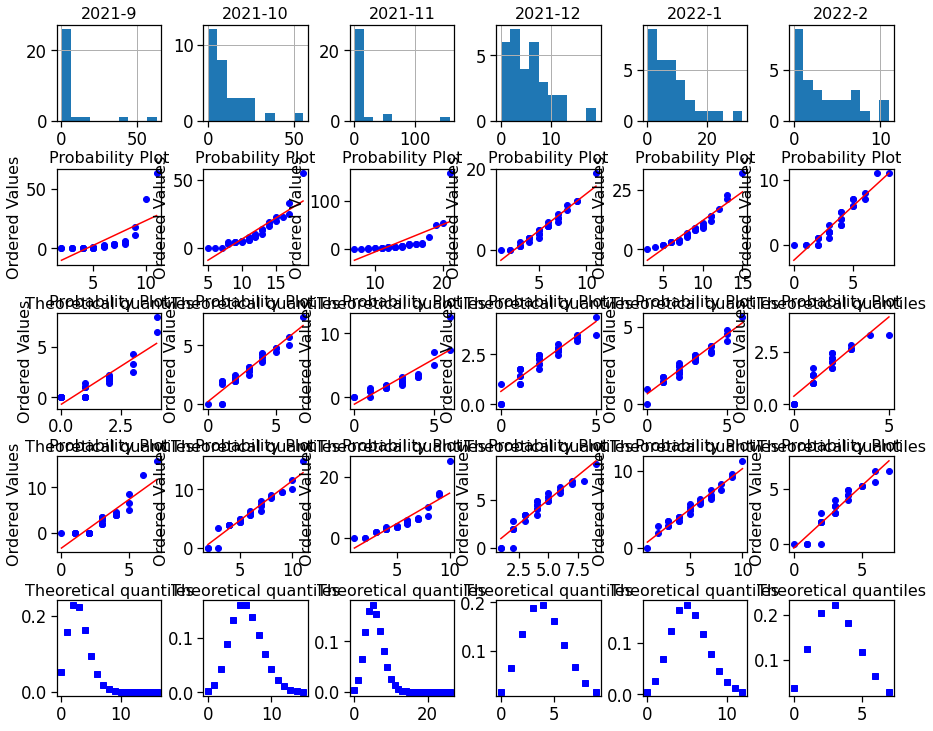

ratio_var_by_mean: 		 [31.4  11.33 67.34  3.46  6.07  2.87]
ratio_var_by_mean_sqrt: 	 [2.57 0.9  2.4  0.53 0.54 0.63]
ratio_var_by_mean_2sqrt: 	 [5.13 1.79 4.79 1.05 1.08 1.26]


In [330]:
start, end = "2021-09", "2022-3"
 
is_index_is_date = False
if "hour" in df_day1.columns:
  df_day1.set_index("hour", inplace=True)
  is_index_is_date=True

date_col = pd.date_range(start, end, freq='1M')

product_type = "aggregate_per_row" 
num_row = 6
plt.figure(figsize=(15,num_row*2.5))    
print(f"{product_type}")    

ratio_var_by_mean = []
ratio_var_by_mean_sqrt = []
ratio_var_by_mean_2sqrt = []
plt.grid(True, which='both')
for t, period in enumerate(date_col):
    t+=1
    period = f"{period.year}-{period.month}"    
    ax1 = plt.subplot(num_row, len(date_col), t)
    ax1.set_title(period)
    df_day1.loc[period, product_type].hist(ax=ax1)
    
    plt.subplot(num_row, len(date_col), t+len(date_col))
    stats.probplot(
        df_day1.loc[period, product_type], 
        dist='poisson',
        sparams=(df_day1.loc[period, product_type].mean()),
        plot=plt)    
    
    plt.subplot(num_row, len(date_col), t+2*len(date_col))
    df_temp = pd.DataFrame({"sqrt": np.sqrt(df_day1.loc[period, product_type].values)})
    stats.probplot(
        df_temp["sqrt"], 
        dist='poisson',
        sparams=(df_temp["sqrt"].mean()),
        plot=plt)
    
    plt.subplot(num_row, len(date_col), t+3*len(date_col))    
    df_temp["2*sqrt"] = 2*np.sqrt(df_day1.loc[period, product_type].values)
    stats.probplot(
        df_temp["2*sqrt"], 
        dist='poisson',
        sparams=(df_temp["2*sqrt"].mean()),
        plot=plt)
    
    plt.subplot(num_row, len(date_col), t+4*len(date_col))      
    plot_poisson(lambda_mean=df_temp["2*sqrt"].mean(),
                 x=np.arange(0, df_temp["2*sqrt"].max()+1),
                 is_show=False, 
                #  xlab="Average num of total unit sold daily",
                #  ylab="Probability"
                 )
    
    # plt.subplot(num_row, len(date_col), t+5*len(date_col))      
    # df_temp["2*sqrt"].hist()
    
    ratio_var_by_mean_2sqrt.append(df_temp["2*sqrt"].var()/df_temp["2*sqrt"].mean())
    ratio_var_by_mean_sqrt.append(df_temp["sqrt"].var()/df_temp["sqrt"].mean())
    ratio_var_by_mean.append(df_day1.loc[period, product_type].var()/df_day1.loc[period, product_type].mean())

plt.subplots_adjust(wspace=0.4, hspace=0.5)    
plt.show()

print(f"ratio_var_by_mean: \t\t", np.around(ratio_var_by_mean, 2))
print(f"ratio_var_by_mean_sqrt: \t", np.around(ratio_var_by_mean_sqrt, 2))
print(f"ratio_var_by_mean_2sqrt: \t", np.around(ratio_var_by_mean_2sqrt, 2))

if is_index_is_date==True:
    df_day1.reset_index(inplace=True)

## Hypothesis from data exploration (TODO)

---



For the total unit sold, we form 2 hypothesis below
---
$H_0$: Average number of order per day for Dec and Jan are the same
---
$H_1$: Average number of order per day for Dec and Jan are different
---



In [331]:
# Hypothesis test 
# TBD

## Conclusion on saving man-power cost

Above probability plot for non-peak Month (2021 Dec to 2022 Feb) shows there is 30% to 40% chance of receiving average 3 to 5 order daily.

This workload is still a managible within current assigned hours for our part-timer.

Therefore, there is no need to increase part-timer working hour. However, there is risk of delaying fulfillment for sudden peak of order in non-peak month.


# Soon Chee's section

1.   List item
2.   List item



## Business question
   To review the sales performance by product types

## Data pre-processing

In [332]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfsc = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfsc = pd.read_csv(csv_pathname)

display(dfsc.head())
 

read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


,hour,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,...,gross_profit,gross_margin,units_per_transaction,customers,pending_sales,net_quantity,ordered_item_quantity,average_units_ordered,returned_item_quantity,percent_of_sales_with_staff_help
0,9/1/2021 0:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
1,9/1/2021 1:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
2,9/1/2021 2:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
3,9/1/2021 3:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
4,9/1/2021 4:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0


In [333]:
dfsc.columns

Index(['hour', 'adjustment', 'cancelled', 'financial_status',
       'fulfillment_status', 'order_id', 'order_name', 'purchase_option',
       'sale_kind', 'sale_line_type', 'cost_tracked', 'billing_company',
       'billing_city', 'billing_region', 'billing_country',
       'billing_postal_code', 'customer_id', 'customer_type',
       'marketing_event_target', 'marketing_event_type',
       'utm_campaign_content', 'utm_campaign_medium', 'utm_campaign_name',
       'utm_campaign_source', 'utm_campaign_term', 'pos_location_name',
       'product_id', 'product_title', 'product_price', 'product_type',
       'product_vendor', 'variant_id', 'variant_sku', 'variant_title',
       'api_client_title', 'shipping_city', 'shipping_region',
       'shipping_country', 'shipping_postal_code', 'staff_id', 'staff_name',
       'id_of_staff_who_helped_with_sale',
       'name_of_staff_who_helped_with_sale', 'referrer_host', 'referrer_name',
       'referrer_path', 'referrer_source', 'referrer_url', 'o

In [334]:
# filter by fulfilled orders

dfsc1=dfsc.loc[dfsc['fulfillment_status'] == 'fulfilled']
dfsc1.shape

(2858, 69)

In [335]:
# filter by actual orders only

dfsc1=dfsc1.loc[dfsc1['orders'] != 0]
dfsc1.shape

(1983, 69)

In [336]:
# remove missing data in product title

dfsc1=dfsc1.loc[dfsc1['product_title'].notna()]
dfsc1.shape

(1983, 69)

In [337]:
# remove missing data in total cost

dfsc1=dfsc1.loc[dfsc1["total_cost"] != 0]
dfsc1.shape

(1799, 69)

In [338]:
# remove missing data in gross margin

dfsc1=dfsc1.loc[dfsc1['gross_margin'].notna()]
dfsc1.shape

(1754, 69)

## Prepare dataframe for hypothesis testing

In [339]:
# filter view by selected columns

dfsc2 = dfsc1[['fulfillment_status','product_title','product_type','product_price','net_quantity','net_sales','discounts', 'taxes', "total_sales",'total_cost','gross_profit','gross_margin']]

In [340]:
dfsc2.describe()

,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin
count,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000
mean,45.203883,1.319270,49.175279,-2.304379,3.358734,52.534014,45.623877,3.551403,0.079037
std,50.700107,0.961675,61.840407,5.332997,4.021070,65.531248,59.896964,14.434321,1.379372
min,2.900000,1.000000,0.080000,-46.740000,0.000000,0.080000,1.230000,-123.350000,-47.125000
25%,16.450000,1.000000,17.660000,-2.460000,1.220000,18.900000,13.150000,1.032500,0.030270
50%,29.900000,1.000000,32.360000,0.000000,2.250000,34.625000,26.750000,4.165000,0.178080
75%,50.900000,1.000000,55.050000,0.000000,3.850000,58.900000,51.530000,8.020000,0.299450
max,858.900000,15.000000,1068.780000,0.000000,74.820000,1143.600000,917.320000,187.780000,0.724350


### Normality check using Anderson-Darling test

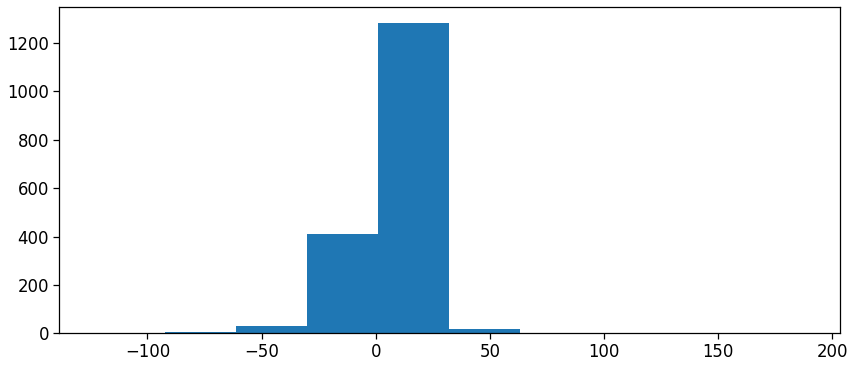

In [341]:
#Checking Histogram
import matplotlib
from matplotlib import pyplot 
%matplotlib inline
pyplot.figure(figsize=(14,6))
pyplot.hist(dfsc2['gross_profit'])
pyplot.show()

In [342]:
alpha_value = 0.05
#random_seed = 123

In [343]:
# Anderson-Darling test
from statsmodels.stats.diagnostic import normal_ad

#(test_statistic, p_value) = normal_ad(mydf['gross_profit'])      
(test_statistic, p_value) = normal_ad(dfsc2['gross_profit'])

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3),"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  inf
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/_adnorm.py:67: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


Conclusion: Gross Profit Sample likely not follow a normal distribution.
Next to check if the data can be transformed to follow a normal distribution.

### Data transformation using Quantile Transformer

In [344]:
#Define function for comparing two plots
def compare_plot(feature, transformed_feature):
    plt.rcParams["figure.figsize"] = 13,5
    fig,ax = plt.subplots(1,2)

    stdDev = np.round(np.std(feature)[0],4) # for normal distribution, standard deviation is 1
    skewness = np.round(skew(feature),4) # for normal distribution, skewness = 0
    excess_kurtosis = np.round(kurtosis(feature),4) # for normal distribution, excess kurtosis = 0
    sns.histplot(feature, kde=True, ax=ax[0], legend=False)
    ax[0].set_xlabel(feature.columns[0])
    ax[0].set_title("ORIGINAL \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(stdDev, skewness, excess_kurtosis));

    transformed_stdDev = np.round(np.std(transformed_feature)[0],4)
    transformed_skewness = np.round(skew(transformed_feature),4)
    transformed_excess_kurtosis = np.round(kurtosis(transformed_feature),4)
    sns.histplot(transformed_feature, kde=True, ax=ax[1], legend=False)
    ax[1].set_xlabel(feature.columns[0])
    ax[1].set_title("TRANSFORMED \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(transformed_stdDev, transformed_skewness, transformed_excess_kurtosis));

Performing Quantile Transformation on the sample.

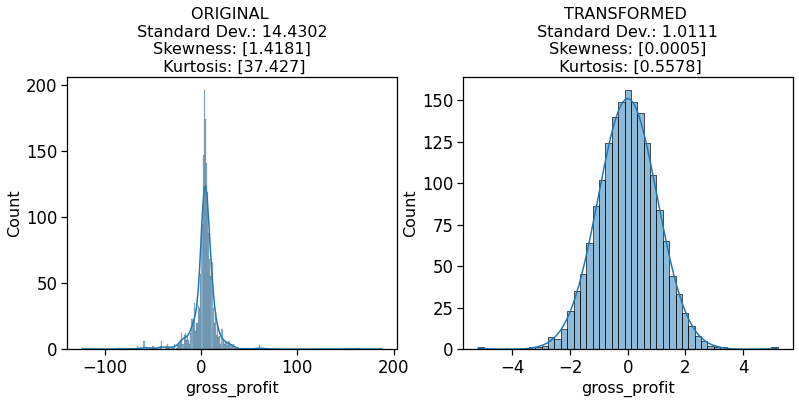

In [345]:
from sklearn.preprocessing import QuantileTransformer

# Select feature
feature = dfsc2[['gross_profit']]

# Transformation
quantile = QuantileTransformer(output_distribution='normal', n_quantiles=len(feature)) # with gaussian output
quantile.fit(feature) # to avoid data leakage, only fit to training data
transformed_feature = quantile.transform(feature) # then perform transform on both training data and test data.
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

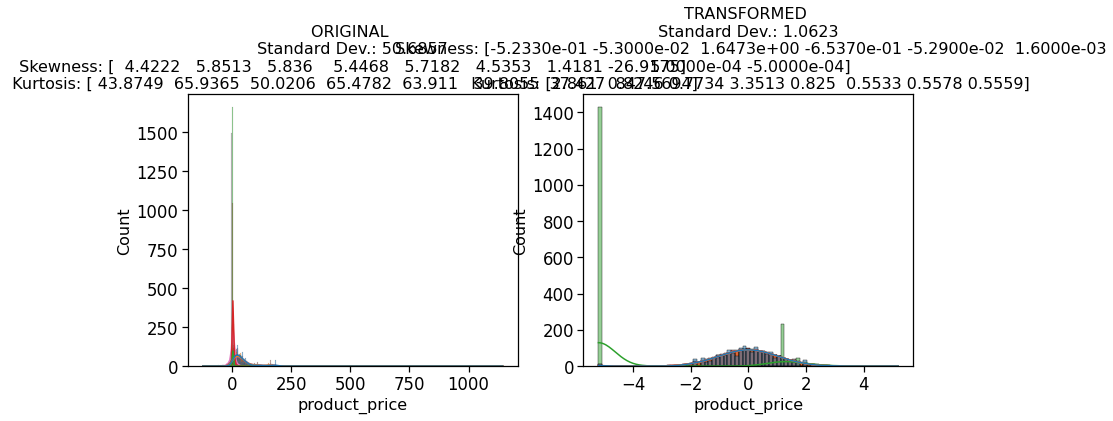

In [346]:
from sklearn.preprocessing import QuantileTransformer

# Select feature
feature = dfsc2[['product_price','net_sales', 'net_quantity','taxes', "total_sales",'total_cost','gross_profit','gross_margin']]

# Transformation
quantile = QuantileTransformer(output_distribution='normal', n_quantiles=len(feature)) # with gaussian output
quantile.fit(feature) # to avoid data leakage, only fit to training data
transformed_feature = quantile.transform(feature) # then perform transform on both training data and test data.
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

Normality test on the transformed data.

In [347]:
# Anderson-Darling test
from statsmodels.stats.diagnostic import normal_ad

for index in range(transformed_feature.shape[1]):
    (test_statistic, p_value) = normal_ad(transformed_feature[index])

    print('For <{}> sample'.format(feature.columns[index]))
    print("The test statistic is: ", round(test_statistic,3))
    print("The p-value is: ", round(p_value,3),"\n")

    if p_value < alpha_value:
        print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
        print("Conclusion: Sample likely not follow a normal distribution.")
    else:
        print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
        print("Conclusion: Sample likely follow a normal distribution.")
    print('----------------')

For <product_price> sample
The test statistic is:  2.726
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.
----------------
For <net_sales> sample
The test statistic is:  0.155
The p-value is:  0.956 

At 0.05 level of significance, we FAILED TO REJECT null hypothesis.
Conclusion: Sample likely follow a normal distribution.
----------------
For <net_quantity> sample
The test statistic is:  470.196
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.
----------------
For <taxes> sample
The test statistic is:  3.763
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.
----------------
For <total_sales> sample
The test statistic is:  0.175
The p-value is:  0.924 

At 0.05 level of significance, we FAILED TO REJECT null hypothe

The transformed data for 'gross profit' distribution passed normality check. We can perform parametric tests on the data.

### Coorrelation checks

In [348]:
dfsc2.corr(method="pearson")

,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin
product_price,1.000000,-0.095133,0.831447,-0.303187,0.697042,0.827390,0.841623,0.069722,-0.023935
net_quantity,-0.095133,1.000000,0.283983,-0.139360,0.308884,0.286942,0.229730,0.263366,0.018607
net_sales,0.831447,0.283983,1.000000,-0.265722,0.912755,0.999686,0.972385,0.249231,-0.003934
discounts,-0.303187,-0.139360,-0.265722,1.000000,-0.293669,-0.268776,-0.310423,0.149714,0.160124
taxes,0.697042,0.308884,0.912755,-0.293669,1.000000,0.922708,0.908342,0.141205,-0.005669
total_sales,0.827390,0.286942,0.999686,-0.268776,0.922708,1.000000,0.973356,0.243858,-0.004060
total_cost,0.841623,0.229730,0.972385,-0.310423,0.908342,0.973356,1.000000,0.016332,-0.042307
gross_profit,0.069722,0.263366,0.249231,0.149714,0.141205,0.243858,0.016332,1.000000,0.158705
gross_margin,-0.023935,0.018607,-0.003934,0.160124,-0.005669,-0.004060,-0.042307,0.158705,1.000000


In [349]:
dfsc2.corr(method="spearman")

,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin
product_price,1.000000,-0.123928,0.891858,-0.172524,0.874059,0.891889,0.888704,0.032356,-0.527502
net_quantity,-0.123928,1.000000,0.269270,-0.071573,0.266526,0.269117,0.226454,0.190041,0.021898
net_sales,0.891858,0.269270,1.000000,-0.111623,0.980106,0.999944,0.960794,0.124659,-0.475776
discounts,-0.172524,-0.071573,-0.111623,1.000000,-0.109655,-0.111076,-0.144043,0.093549,0.184844
taxes,0.874059,0.266526,0.980106,-0.109655,1.000000,0.981302,0.943035,0.103508,-0.477322
total_sales,0.891889,0.269117,0.999944,-0.111076,0.981302,1.000000,0.960878,0.124090,-0.476207
total_cost,0.888704,0.226454,0.960794,-0.144043,0.943035,0.960878,1.000000,-0.081865,-0.669434
gross_profit,0.032356,0.190041,0.124659,0.093549,0.103508,0.124090,-0.081865,1.000000,0.681881
gross_margin,-0.527502,0.021898,-0.475776,0.184844,-0.477322,-0.476207,-0.669434,0.681881,1.000000


In [350]:
from scipy.stats import pearsonr, spearmanr

(sprho, p_value) = spearmanr(dfsc2['gross_profit'],dfsc2['product_type'], nan_policy="omit")
#omit comes in when suppose missing values are present in data, you need to delete or remove otherwise
#it wouldn't calculate, since missing or na can't. If you didnt turn on the flag you will get an issue later

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The correlation coefficient is:  0.07
The p-value is: 0.00565
At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Monotonic association likely exist between these two variables.


The column relationships we are interested in are gross profit and product type.  As the spearmanr test checks, they likely share a monotonic relationship.

### Import transformed data into dataframe

In [351]:
display(transformed_feature)
dfsc_main = dfsc2.reset_index(drop=True).join(transformed_feature)

for index in range(transformed_feature.shape[1]):
    transform = feature.columns[index] + "_transform" 
    dfsc_main.rename(columns={index: transform}, inplace=True)

display(dfsc_main.head())

,0,1,2,3,4,5,6,7
0,0.243319,0.090206,-5.199338,0.095233,0.093078,0.099543,0.379244,-0.007150
1,-1.221477,-1.272824,-5.199338,-1.222986,-1.266421,-1.775169,0.332775,2.124162
2,-2.231164,-2.197958,-5.199338,-2.037071,-2.197958,-1.688725,-0.703956,-0.005005
3,-0.593619,-0.678534,-5.199338,-0.650891,-0.676735,-0.653544,-0.030748,0.305691
4,-1.343465,-1.427447,-5.199338,-1.398350,-1.431418,-1.483095,-0.098106,1.339948
...,...,...,...,...,...,...,...,...
1749,1.016935,0.811638,-5.199338,0.817616,0.811638,0.554001,1.276045,0.203733
1750,0.898195,0.704872,-5.199338,0.710382,0.704872,0.654429,0.065823,-0.451742
1751,-1.343465,-0.716838,1.177443,-0.698470,-0.716838,-0.929677,0.585962,1.319183
1752,-0.815620,-0.921994,-5.199338,-0.891792,-0.918718,-0.948567,-0.006435,0.794856


,fulfillment_status,product_title,product_type,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
0,fulfilled,FANCL Men All-in-One Skin Conditioner Moisture...,Face Moisturizer,36.9,1,34.49,0.0,2.41,36.9,28.40,6.09,0.17657,0.243319,0.090206,-5.199338,0.095233,0.093078,0.099543,0.379244,-0.007150
1,fulfilled,DHC persistent vitamin C,Daily & Health Supplements,9.9,1,9.25,0.0,0.65,9.9,3.39,5.86,0.63351,-1.221477,-1.272824,-5.199338,-1.222986,-1.266421,-1.775169,0.332775,2.124162
2,fulfilled,ETVOS Foaming Net,Tools,4.9,1,4.58,0.0,0.32,4.9,3.77,0.81,0.17685,-2.231164,-2.197958,-5.199338,-2.037071,-2.197958,-1.688725,-0.703956,-0.005005
3,fulfilled,Kobayashi Dietary Supplements Nattowakize Dha...,Daily & Health Supplements,18.9,1,17.66,0.0,1.24,18.9,13.63,4.03,0.22819,-0.593619,-0.678534,-5.199338,-0.650891,-0.676735,-0.653544,-0.030748,0.305691
4,fulfilled,PELICAN For Back Medicinal Soap 135g,Body Care,8.9,1,8.32,0.0,0.58,8.9,4.61,3.71,0.44591,-1.343465,-1.427447,-5.199338,-1.398350,-1.431418,-1.483095,-0.098106,1.339948


In [352]:
dfsc_main.corr(method="pearson")

,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
product_price,1.000000,-0.095133,0.831447,-0.303187,0.697042,0.827390,0.841623,0.069722,-0.023935,0.784481,0.727850,-0.093616,0.552707,0.728065,0.732166,-0.007078,-0.351719
net_quantity,-0.095133,1.000000,0.283983,-0.139360,0.308884,0.286942,0.229730,0.263366,0.018607,-0.142469,0.246340,0.749203,0.234328,0.246144,0.197929,0.247510,0.068449
net_sales,0.831447,0.283983,1.000000,-0.265722,0.912755,0.999686,0.972385,0.249231,-0.003934,0.650083,0.770326,0.242582,0.614363,0.770324,0.755174,0.120598,-0.274193
discounts,-0.303187,-0.139360,-0.265722,1.000000,-0.293669,-0.268776,-0.310423,0.149714,0.160124,-0.299355,-0.241029,-0.125067,-0.234907,-0.240956,-0.320269,0.148673,0.300693
taxes,0.697042,0.308884,0.912755,-0.293669,1.000000,0.922708,0.908342,0.141205,-0.005669,0.632075,0.776573,0.265746,0.761249,0.777382,0.761260,0.076343,-0.295062
total_sales,0.827390,0.286942,0.999686,-0.268776,0.922708,1.000000,0.973356,0.243858,-0.004060,0.652254,0.774591,0.245226,0.626472,0.774639,0.759353,0.118491,-0.276855
total_cost,0.841623,0.229730,0.972385,-0.310423,0.908342,0.973356,1.000000,0.016332,-0.042307,0.673300,0.774578,0.219084,0.637622,0.774725,0.797084,-0.081123,-0.409340
gross_profit,0.069722,0.263366,0.249231,0.149714,0.141205,0.243858,0.016332,1.000000,0.158705,-0.008817,0.086072,0.130169,-0.013798,0.085457,-0.072230,0.853306,0.523889
gross_margin,-0.023935,0.018607,-0.003934,0.160124,-0.005669,-0.004060,-0.042307,0.158705,1.000000,-0.018840,0.134796,0.010955,0.117808,0.134789,-0.047500,0.191984,0.370479
product_price_transform,0.784481,-0.142469,0.650083,-0.299355,0.632075,0.652254,0.673300,-0.008817,-0.018840,1.000000,0.865157,-0.126401,0.749077,0.865210,0.875276,0.023619,-0.476067


In [353]:
dfsc_main.corr(method="spearman")

,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
product_price,1.000000,-0.123928,0.891858,-0.172524,0.874059,0.891889,0.888704,0.032356,-0.527502,1.000000,0.891858,-0.123928,0.874059,0.891889,0.888704,0.032356,-0.527502
net_quantity,-0.123928,1.000000,0.269270,-0.071573,0.266526,0.269117,0.226454,0.190041,0.021898,-0.123928,0.269270,1.000000,0.266526,0.269117,0.226454,0.190041,0.021898
net_sales,0.891858,0.269270,1.000000,-0.111623,0.980106,0.999944,0.960794,0.124659,-0.475776,0.891858,1.000000,0.269270,0.980106,0.999944,0.960794,0.124659,-0.475776
discounts,-0.172524,-0.071573,-0.111623,1.000000,-0.109655,-0.111076,-0.144043,0.093549,0.184844,-0.172524,-0.111623,-0.071573,-0.109655,-0.111076,-0.144043,0.093549,0.184844
taxes,0.874059,0.266526,0.980106,-0.109655,1.000000,0.981302,0.943035,0.103508,-0.477322,0.874059,0.980106,0.266526,1.000000,0.981302,0.943035,0.103508,-0.477322
total_sales,0.891889,0.269117,0.999944,-0.111076,0.981302,1.000000,0.960878,0.124090,-0.476207,0.891889,0.999944,0.269117,0.981302,1.000000,0.960878,0.124090,-0.476207
total_cost,0.888704,0.226454,0.960794,-0.144043,0.943035,0.960878,1.000000,-0.081865,-0.669434,0.888704,0.960794,0.226454,0.943035,0.960878,1.000000,-0.081865,-0.669434
gross_profit,0.032356,0.190041,0.124659,0.093549,0.103508,0.124090,-0.081865,1.000000,0.681881,0.032356,0.124659,0.190041,0.103508,0.124090,-0.081865,1.000000,0.681881
gross_margin,-0.527502,0.021898,-0.475776,0.184844,-0.477322,-0.476207,-0.669434,0.681881,1.000000,-0.527502,-0.475776,0.021898,-0.477322,-0.476207,-0.669434,0.681881,1.000000
product_price_transform,1.000000,-0.123928,0.891858,-0.172524,0.874059,0.891889,0.888704,0.032356,-0.527502,1.000000,0.891858,-0.123928,0.874059,0.891889,0.888704,0.032356,-0.527502


In [354]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(dfsc_main['gross_profit_transform'],dfsc_main['product_type'], nan_policy="omit")
#omit comes in when suppose missing values are present in data, you need to delete or remove otherwise
#it wouldn't calculate, since missing or na can't. If you didnt turn on the flag you will get an issue later

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The correlation coefficient is:  0.07
The p-value is: 0.00565
At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Monotonic association likely exist between these two variables.


## Hypothesis Testing using One sample Z-Test (Test of Means) - Parametric Test

### Hypothesis Test using general non-probability sample and random sample

Test the hypothesis that sample gross profit mean not is equal to population gross profit mean

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu \neq \mu_0
\end{align}$

In [355]:
sample_percent = 0.01
alpha_value = 0.05
random_seed = 123

In [356]:
# Get statistic of population data (count, mean, variance, standard deviation). Round to the nearest whole number.
df_col = dfsc_main['gross_profit_transform']

pop_count = df_col.count()
pop_mean = df_col.mean()
pop_var = (df_col.std())**2
pop_std = df_col.std()

print ("Population count = ", pop_count)
print ("Population mean = ", pop_mean)
print ("Population variance = ", pop_var)
print ("Population standard deviation = ", pop_std)
print ("Unique count for Product Tyoe = ", len(dfsc_main["product_type"].unique()))

Population count =  1754
Population mean =  0.00027208568786822135
Population variance =  1.022905252991012
Population standard deviation =  1.0113877856643376
Unique count for Product Tyoe =  69


In [357]:
# Extract a sample from population data using non-probability based sampling

sample_count = round(pop_count*sample_percent)
sample_df = dfsc_main[:sample_count]
sample_df_col = sample_df['gross_profit_transform']

# Get statistic of sample data (count, mean, variance, standard deviation). Round to the nearest whole number.

sample_mean = sample_df_col.mean()
sample_var = sample_df_col.std()**2
sample_std = sample_df_col.std()

print ("Sample count = ", sample_count)
print ("Sample mean = ", sample_mean)
print ("Sample variance = ", sample_var)
print ("Sample standard deviation = ", sample_std)
print ("Unique count for Product Type = ", len(sample_df["product_type"].unique()))

Sample count =  18
Sample mean =  0.21328355883409697
Sample variance =  1.250940738285029
Sample standard deviation =  1.1184546205747594
Unique count for Product Type =  12


In [358]:
# Extract a sample from population data using stratified random sampling (probability based sampling)

from sklearn.model_selection import StratifiedShuffleSplit
stratifiedSampling = StratifiedShuffleSplit(n_splits=1, test_size=sample_percent, random_state=random_seed)

for x, y in stratifiedSampling.split(dfsc_main, dfsc_main.fulfillment_status):
    stratified_sample_df = dfsc_main.iloc[y].sort_values(by=['product_type','product_title'])

stratified_sample_df_col = stratified_sample_df['gross_profit_transform']

# Get statistic of sample data (count, mean, variance, standard deviation). Round to the nearest whole number.
    
stratified_sample_mean = stratified_sample_df_col.mean()
stratified_sample_var = stratified_sample_df_col.std()**2
stratified_sample_std = stratified_sample_df_col.std()

print ("Stratified Sample count = ", sample_count)
print ("Stratified Sample mean = ", stratified_sample_mean)
print ("Stratified Sample variance = ", stratified_sample_var)
print ("Stratified Sample standard deviation = ", stratified_sample_std)
print ("Unique count for Product Type = ", len(stratified_sample_df["product_type"].unique()))

Stratified Sample count =  18
Stratified Sample mean =  -0.12238610460781738
Stratified Sample variance =  0.9801301972527011
Stratified Sample standard deviation =  0.9900152510202563
Unique count for Product Type =  14


In [359]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='two-sided')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  0.808
The p-value is:  0.419
At 0.05 level of significance, we failed to reject null hypothesis.


In [360]:
# Hypothesis test on stratified random sampling (probability based sampling)

(test_statistic, p_value) = weightstats.ztest(stratified_sample_df_col, value=pop_mean, alternative='two-sided')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -0.526
The p-value is:  0.599
At 0.05 level of significance, we failed to reject null hypothesis.


Conclusion: Both tests failed to reject null hypothesis.  There is insufficient evidence to show the sample gross profit mean is equal to population gross profit mean.

In [361]:
# extract the list of unique product types

product_type_list = dfsc_main['product_type'].unique()
print(product_type_list)

['Face Moisturizer' 'Daily & Health Supplements' 'Tools' 'Body Care'
 'Dental Care' 'Insecticide' 'Facial Mask' 'Conditioner' 'Serum' 'Lotion'
 'Concealers' 'Essence' 'Baby Hair Care' 'Beauty Supplements'
 'Weight Management' 'Feminine Wash' 'Eyebrow' 'Cleanser' 'Hair Powder'
 'Beauty Tools' 'Energy Boosting' 'UV Protector' 'Face Powder'
 'Mosquito Repellent' 'Shampoo' 'Makeup Remover' 'Eye Cream' 'Facial Oil'
 "Children's Dental Care" 'Hair Colour' 'Posture Belt' 'Hair Treatment'
 'Home & Living' 'Hand Care' 'Emulsion' 'Detergent' 'Exfoliator'
 'Whitening Cream' 'Eye Mask' 'Eyelash' 'Mascara' 'Air Freshener'
 'Beverage' 'Foundation' 'Gift Set/Box' 'Toner' 'Lip Balm'
 'Baby Dental Care' 'Blush' 'Feeding' 'Cotton Pad' 'Deodorant'
 'Baby Body Care' 'Foot Care' 'Cleaning Agent' 'Eye Liner'
 'Body Hair Removal' 'Lipstick' 'Deodorizer' 'Eyeshadow' 'Hand Mask'
 'Mother Body Care' 'Primer' 'Stain Remover' 'Highlighter' 'Socks'
 'Hair Brush' "Children's Glasses" 'Milk Bottle']


In [362]:
# create a list for later sorting to extract Top 10 values

product_type_mean = []

for index in range(len(product_type_list)):
    dfsc_temp = dfsc_main[dfsc_main['product_type'] == product_type_list[index]]
    product_type_mean.append([product_type_list[index], dfsc_temp['gross_profit_transform'].count(), dfsc_temp['gross_profit_transform'].mean(), dfsc_temp['gross_profit'].mean(), dfsc_temp['net_sales'].mean(),dfsc_temp['product_price'].mean()])


In [363]:
dfsc_product_type_mean = pd.DataFrame(product_type_mean)

In [364]:
dfsc_product_type_mean.rename(columns={0: 'product_type'}, inplace=True)
dfsc_product_type_mean.rename(columns={1: 'transaction_count'}, inplace=True)
dfsc_product_type_mean.rename(columns={2: 'gross_profit_transform_mean'}, inplace=True)
dfsc_product_type_mean.rename(columns={3: 'gross_profit_mean'}, inplace=True)
dfsc_product_type_mean.rename(columns={4: 'net_sales_mean'}, inplace=True)
dfsc_product_type_mean.rename(columns={5: 'product_type_price_mean'}, inplace=True)
dfsc_product_type_mean

,product_type,transaction_count,gross_profit_transform_mean,gross_profit_mean,net_sales_mean,product_type_price_mean
0,Face Moisturizer,57,-0.205484,-0.050175,62.992105,62.008596
1,Daily & Health Supplements,120,0.503420,8.687500,39.431083,31.076833
2,Tools,1,-0.703956,0.810000,4.580000,4.900000
3,Body Care,54,0.018224,4.398519,21.445185,23.188519
4,Dental Care,49,-0.130285,4.148776,11.333469,8.169796
...,...,...,...,...,...,...
64,Highlighter,1,1.285789,13.490000,106.450000,113.900000
65,Socks,3,0.616209,9.256667,54.020000,28.900000
66,Hair Brush,1,0.165912,4.940000,19.530000,20.900000
67,Children's Glasses,1,0.735451,8.310000,50.370000,53.900000


In [365]:
dfsc_sorted = dfsc_product_type_mean.sort_values(by=['gross_profit_mean'])

# Top 10 product types based on gross profit mean
display(dfsc_sorted[['product_type','gross_profit_mean']].tail(10))

,product_type,gross_profit_mean
60,Hand Mask,9.440000
57,Lipstick,9.680000
24,Shampoo,9.886765
42,Beverage,10.716364
7,Conditioner,10.833846
12,Baby Hair Care,12.005385
8,Serum,13.093556
64,Highlighter,13.490000
20,Energy Boosting,14.513333
44,Gift Set/Box,44.680000


### Hypothesis Test for Top 10 product types based on transaction counts

Test the hypothesis that the sample gross profit mean of the Top 10 product types based on transactions is greater than the population gross profit mean.

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu > \mu_0
\end{align}$

In [366]:
# Top 10 product types based on transaction count
dfsc_sorted = dfsc_product_type_mean.sort_values(by=['transaction_count', 'gross_profit_transform_mean'])
top = dfsc_sorted.tail(10)
display(top[['product_type','transaction_count','gross_profit_transform_mean','gross_profit_mean']])
print("")
dfsc_top = dfsc_main.loc[dfsc_main['product_type'].isin(top['product_type'])]
display(dfsc_top.head())
dfsc_top['gross_profit_transform'].describe()

,product_type,transaction_count,gross_profit_transform_mean,gross_profit_mean
38,Eye Mask,56,-0.460179,-4.678036
0,Face Moisturizer,57,-0.205484,-0.050175
9,Lotion,78,-0.452007,-1.589744
21,UV Protector,89,-0.211742,0.834831
13,Beauty Supplements,89,-0.115256,3.764719
11,Essence,95,-0.571665,-3.609474
1,Daily & Health Supplements,120,0.503420,8.687500
17,Cleanser,131,-0.235046,2.489008
14,Weight Management,150,0.454442,8.558533
6,Facial Mask,180,0.058555,4.253000


,fulfillment_status,product_title,product_type,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
0,fulfilled,FANCL Men All-in-One Skin Conditioner Moisture...,Face Moisturizer,36.9,1,34.49,0.0,2.41,36.9,28.40,6.09,0.17657,0.243319,0.090206,-5.199338,0.095233,0.093078,0.099543,0.379244,-0.007150
1,fulfilled,DHC persistent vitamin C,Daily & Health Supplements,9.9,1,9.25,0.0,0.65,9.9,3.39,5.86,0.63351,-1.221477,-1.272824,-5.199338,-1.222986,-1.266421,-1.775169,0.332775,2.124162
3,fulfilled,Kobayashi Dietary Supplements Nattowakize Dha...,Daily & Health Supplements,18.9,1,17.66,0.0,1.24,18.9,13.63,4.03,0.22819,-0.593619,-0.678534,-5.199338,-0.650891,-0.676735,-0.653544,-0.030748,0.305691
7,fulfilled,Creer Beaute La Rose De Versailles Face Mask 2...,Facial Mask,6.9,2,12.90,0.0,0.90,13.8,7.62,5.28,0.40930,-1.582569,-0.953061,1.177443,-0.921994,-0.953061,-1.009767,0.226415,1.176014
8,fulfilled,FANCL Men All-in-One Skin Conditioner Moisture...,Face Moisturizer,36.9,1,34.48,0.0,2.42,36.9,28.40,6.08,0.17633,0.243319,0.085900,-5.199338,0.103855,0.093078,0.099543,0.375406,-0.009295


count    1045.000000
mean       -0.045765
std         1.062309
min        -5.199338
25%        -0.848979
50%        -0.016445
75%         0.708543
max         5.199338
Name: gross_profit_transform, dtype: float64

In [367]:
# Get statistic of population data (count, mean, variance, standard deviation). Round to the nearest whole number.
dfsc_col = dfsc_main['gross_profit_transform']

pop_count = dfsc_col.count()
pop_mean = dfsc_col.mean()
pop_var = (dfsc_col.std())**2
pop_std = dfsc_col.std()

print ("Population count = ", pop_count)
print ("Population mean = ", pop_mean)
print ("Population variance = ", pop_var)
print ("Population standard deviation = ", pop_std)
print ("Unique count for Product Tyoe = ", len(dfsc_main["product_type"].unique()))

Population count =  1754
Population mean =  0.00027208568786822135
Population variance =  1.022905252991012
Population standard deviation =  1.0113877856643376
Unique count for Product Tyoe =  69


In [368]:
# Extract a sample from population data using non-probability based sampling

sample_count = dfsc_top['gross_profit_transform'].count()
sample_df = dfsc_top
sample_df_col = sample_df['gross_profit_transform']

# Get statistic of sample data (count, mean, variance, standard deviation). Round to the nearest whole number.

sample_mean = sample_df_col.mean()
sample_var = sample_df_col.std()**2
sample_std = sample_df_col.std()

print ("Sample count = ", sample_count)
print ("Sample mean = ", sample_mean)
print ("Sample variance = ", sample_var)
print ("Sample standard deviation = ", sample_std)
print ("Unique count for Product Type = ", len(sample_df["product_type"].unique()))

Sample count =  1045
Sample mean =  -0.045765010602426534
Sample variance =  1.1285009548313927
Sample standard deviation =  1.0623092557402447
Unique count for Product Type =  10


In [369]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='larger')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -1.401
The p-value is:  0.919
At 0.05 level of significance, we failed to reject null hypothesis.


There is insufficient evidence to support that the sample gross profit mean of the Top 10 product types based on transactions is greater than the population gross profit mean. 

### Hypothesis Test for Top 10 product types based on net sales mean

Test the hypothesis that the sample gross profit mean of the Top 10 product types based on net sales mean is greater than the population gross profit mean.

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu > \mu_0
\end{align}$

In [370]:
# Top 10 product types based on net sales mean
dfsc_sorted = dfsc_product_type_mean.sort_values(by=['net_sales_mean'])
top = dfsc_sorted.tail(10)
display(top[['product_type','net_sales_mean','gross_profit_mean']])
print("")
dfsc_top = dfsc_main.loc[dfsc_main['product_type'].isin(top['product_type'])]
display(dfsc_top.head())
dfsc_top['gross_profit_transform'].describe()

,product_type,net_sales_mean,gross_profit_mean
0,Face Moisturizer,62.992105,-0.050175
61,Mother Body Care,64.242727,3.285455
34,Emulsion,65.952059,-8.545294
26,Eye Cream,87.355185,-5.763333
13,Beauty Supplements,96.413933,3.764719
64,Highlighter,106.450000,13.490000
45,Toner,107.054074,-9.148889
11,Essence,124.667053,-3.609474
8,Serum,126.233556,13.093556
44,Gift Set/Box,297.365000,44.680000


,fulfillment_status,product_title,product_type,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
0,fulfilled,FANCL Men All-in-One Skin Conditioner Moisture...,Face Moisturizer,36.9,1,34.49,0.00,2.41,36.90,28.40,6.09,0.17657,0.243319,0.090206,-5.199338,0.095233,0.093078,0.099543,0.379244,-0.007150
8,fulfilled,FANCL Men All-in-One Skin Conditioner Moisture...,Face Moisturizer,36.9,1,34.48,0.00,2.42,36.90,28.40,6.08,0.17633,0.243319,0.085900,-5.199338,0.103855,0.093078,0.099543,0.375406,-0.009295
11,fulfilled,"SK-II Genoptics Spot Essence, Brightening & Wh...",Serum,270.9,1,229.54,-23.63,16.07,245.61,212.54,17.00,0.07406,2.607252,2.159591,-5.199338,2.206034,2.159591,2.091214,1.541409,-0.488474
14,fulfilled,SK-II x Tokyo Olympics Special Edition Pitera ...,Essence,183.9,2,311.03,-32.71,21.77,332.80,345.18,-34.15,-0.10979,1.953418,2.436462,1.177443,2.529915,2.436462,2.704273,-2.066401,-1.193321
15,fulfilled,SK-II Skin Power Airy Milky Lotion 80g,Face Moisturizer,198.9,1,176.68,-9.20,12.37,189.05,182.19,-5.51,-0.03118,2.276468,1.948622,-5.199338,1.978096,1.948622,1.958259,-1.110065,-0.894989


count    388.000000
mean      -0.266786
std        1.238852
min       -3.253257
25%       -1.230573
50%       -0.429682
75%        0.752918
max        3.253257
Name: gross_profit_transform, dtype: float64

In [371]:
# Extract a sample from population data using non-probability based sampling

sample_count = dfsc_top['gross_profit_transform'].count()
sample_df = dfsc_top
sample_df_col = sample_df['gross_profit_transform']

# Get statistic of sample data (count, mean, variance, standard deviation). Round to the nearest whole number.

sample_mean = sample_df_col.mean()
sample_var = sample_df_col.std()**2
sample_std = sample_df_col.std()

print ("Sample count = ", sample_count)
print ("Sample mean = ", sample_mean)
print ("Sample variance = ", sample_var)
print ("Sample standard deviation = ", sample_std)
print ("Unique count for Product Type = ", len(sample_df["product_type"].unique()))

Sample count =  388
Sample mean =  -0.2667856882117616
Sample variance =  1.534753234892703
Sample standard deviation =  1.2388515790411307
Unique count for Product Type =  10


In [372]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='larger')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -4.246
The p-value is:  1.0
At 0.05 level of significance, we failed to reject null hypothesis.


There is insufficient evidence to support that the sample gross profit mean of the Top 10 product types based on net sales mean is greater than the population gross profit mean.

Test the hypothesis that the sample gross profit mean of the Top 10 product types based on net sales mean is lesser than the population gross profit mean.

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu < \mu_0
\end{align}$

In [373]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='smaller')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -4.246
The p-value is:  0.0
At 0.05 level of significance, we reject null hypothesis.


There is signficant evidence to support that the sample gross profit mean of the Top 10 product types based on net sales mean is lesser than the population gross profit mean.

### Hypothesis Test for Top 10 product types based on product price mean

Test the hypothesis that the sample gross profit mean of the Top 10 product types based on product price mean is greater than the population gross profit mean.

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu > \mu_0
\end{align}$

In [374]:
# Top 10 product types based on product price mean
dfsc_sorted = dfsc_product_type_mean.sort_values(by=['product_type_price_mean'])
top = dfsc_sorted.tail(10)
display(top[['product_type','product_type_price_mean','gross_profit_mean']])
print("")
dfsc_top = dfsc_main.loc[dfsc_main['product_type'].isin(top['product_type'])]
display(dfsc_top.head())
dfsc_top['gross_profit_transform'].describe()

,product_type,product_type_price_mean,gross_profit_mean
10,Concealers,63.654483,0.103448
34,Emulsion,68.540882,-8.545294
61,Mother Body Care,73.809091,3.285455
13,Beauty Supplements,76.609888,3.764719
26,Eye Cream,89.596296,-5.763333
45,Toner,102.046296,-9.148889
64,Highlighter,113.900000,13.490000
11,Essence,122.708842,-3.609474
8,Serum,130.819333,13.093556
44,Gift Set/Box,302.400000,44.680000


,fulfillment_status,product_title,product_type,product_price,net_quantity,net_sales,discounts,taxes,total_sales,total_cost,gross_profit,gross_margin,product_price_transform,net_sales_transform,net_quantity_transform,taxes_transform,total_sales_transform,total_cost_transform,gross_profit_transform,gross_margin_transform
11,fulfilled,"SK-II Genoptics Spot Essence, Brightening & Wh...",Serum,270.9,1,229.54,-23.63,16.07,245.61,212.54,17.00,0.07406,2.607252,2.159591,-5.199338,2.206034,2.159591,2.091214,1.541409,-0.488474
13,fulfilled,CHERYL Pearl Blanc Cream 50g,Concealers,50.9,1,47.57,0.00,3.33,50.90,33.95,13.62,0.28631,0.675837,0.510342,-5.199338,0.517686,0.511157,0.290741,1.298973,0.597888
14,fulfilled,SK-II x Tokyo Olympics Special Edition Pitera ...,Essence,183.9,2,311.03,-32.71,21.77,332.80,345.18,-34.15,-0.10979,1.953418,2.436462,1.177443,2.529915,2.436462,2.704273,-2.066401,-1.193321
19,fulfilled,POLA B.A Liquid 20ml x 12 bottles (2019 New),Beauty Supplements,105.9,2,175.13,-22.81,12.26,187.39,172.50,2.63,0.01501,1.309011,1.911782,1.177443,1.939163,1.911782,1.829577,-0.360869,-0.741084
20,fulfilled,DHC Coix Seed Extract 30 Days 30 Tablets,Beauty Supplements,9.9,1,8.18,-1.07,0.57,8.75,5.67,2.51,0.30684,-1.221477,-1.498298,-5.199338,-1.453679,-1.498298,-1.327766,-0.373872,0.731708


count    360.000000
mean      -0.265199
std        1.252692
min       -3.253257
25%       -1.260070
50%       -0.429682
75%        0.791918
max        3.253257
Name: gross_profit_transform, dtype: float64

In [375]:
# Extract a sample from population data using non-probability based sampling

sample_count = dfsc_top['gross_profit_transform'].count()
sample_df = dfsc_top
sample_df_col = sample_df['gross_profit_transform']

# Get statistic of sample data (count, mean, variance, standard deviation). Round to the nearest whole number.

sample_mean = sample_df_col.mean()
sample_var = sample_df_col.std()**2
sample_std = sample_df_col.std()

print ("Sample count = ", sample_count)
print ("Sample mean = ", sample_mean)
print ("Sample variance = ", sample_var)
print ("Sample standard deviation = ", sample_std)
print ("Unique count for Product Type = ", len(sample_df["product_type"].unique()))

Sample count =  360
Sample mean =  -0.2651987039859596
Sample variance =  1.5692361898980935
Sample standard deviation =  1.2526915781221224
Unique count for Product Type =  10


In [376]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='larger')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -4.021
The p-value is:  1.0
At 0.05 level of significance, we failed to reject null hypothesis.


There is insufficient evidence to support that the sample gross profit mean of the Top 10 product types based on product price mean is greater than the population gross profit mean.

Test the hypothesis that the sample gross profit mean of the Top 10 product types based on product price mean is lesser than the population gross profit mean.

$\begin{align}
Null: & {H_0}:\,\mu = \mu_0 \\ 
Alternative: & {H_1}:\,\mu < \mu_0
\end{align}$

In [377]:
# Hypothesis test on non-probability based sampling

(test_statistic, p_value) = weightstats.ztest(sample_df_col, value=pop_mean, alternative='smaller')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -4.021
The p-value is:  0.0
At 0.05 level of significance, we reject null hypothesis.


There is signficant evidence to support that the sample gross profit mean of the Top 10 product types based on product price mean is lesser than the population gross profit mean.

## Conclusion

High number of transactions, high sales revenues or high priced products are not a guarantee for profitability performance. Further analysis would be needed to understand other factors that can improve profitibility.

# Terry's section

In [378]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dftz = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dftz = pd.read_csv(csv_pathname)

display(dftz.head())


read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


,hour,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,...,gross_profit,gross_margin,units_per_transaction,customers,pending_sales,net_quantity,ordered_item_quantity,average_units_ordered,returned_item_quantity,percent_of_sales_with_staff_help
0,9/1/2021 0:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
1,9/1/2021 1:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
2,9/1/2021 2:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
3,9/1/2021 3:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
4,9/1/2021 4:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0


In [379]:
ecom = dftz
ecom.head()

,hour,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,...,gross_profit,gross_margin,units_per_transaction,customers,pending_sales,net_quantity,ordered_item_quantity,average_units_ordered,returned_item_quantity,percent_of_sales_with_staff_help
0,9/1/2021 0:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
1,9/1/2021 1:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
2,9/1/2021 2:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
3,9/1/2021 3:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
4,9/1/2021 4:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0


In [380]:
ecom_sub = dftz[['discounts', 'utm_campaign_name']]
ecom_sub.head()

,discounts,utm_campaign_name
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


In [381]:
ecom_sub1 = ecom_sub[ecom_sub['discounts'].notna()]
len(ecom_sub1)

6982

In [382]:
ecom_sub2 = ecom_sub1[ecom_sub1['utm_campaign_name'].notna()]
len(ecom_sub2)

186

In [383]:
ecom_sub2.head()

,discounts,utm_campaign_name
245,-10.05,shopify_cart_reminder
247,0.00,shopify_cart_reminder
250,-13.95,shopify_cart_reminder
252,-8.00,shopify_cart_reminder
255,-0.69,shopify_cart_reminder


In [384]:
# Category Count
ecom_sub2['utm_campaign_name'].value_counts()

11.11 SMS                                               58
11_11_sale                                              40
shopify_cart_reminder                                   19
black_fri_sale                                          19
CNY_SMS                                                 15
cny_blast                                               13
christmas2021                                            9
xmas2021                                                 7
Jap Mag                                                  2
s223279083_ss_sg_fbc2_sg-dailyk-shp1111-cpas-traffic     2
sag_organic                                              2
Name: utm_campaign_name, dtype: int64

In [385]:
# Only 87 Rows Has Discounts
ecom_sub2['discounts'].value_counts()

 0.00     99
-3.99      4
-1.42      3
-1.12      3
-6.76      2
          ..
-20.43     1
-12.11     1
-8.40      1
-0.91      1
-2.92      1
Name: discounts, Length: 68, dtype: int64

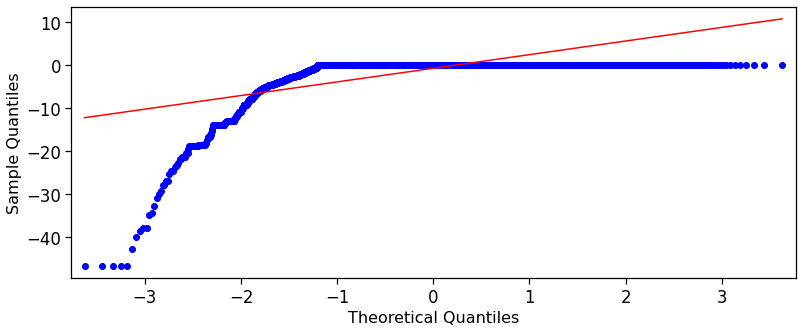

In [386]:
# Quantile-Quantile (Q-Q) Plot
import statsmodels.api as sm

x = dftz['discounts']

qq = sm.qqplot(x, line='s')
plt.show()

Normality Test - Anderson-Darling Test

In [387]:
# Anderson-Darling test
from statsmodels.stats.diagnostic import normal_ad

(test_statistic, p_value) = normal_ad(ecom['discounts'])      

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3),"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  2066.371
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Sample likely not follow a normal distribution.


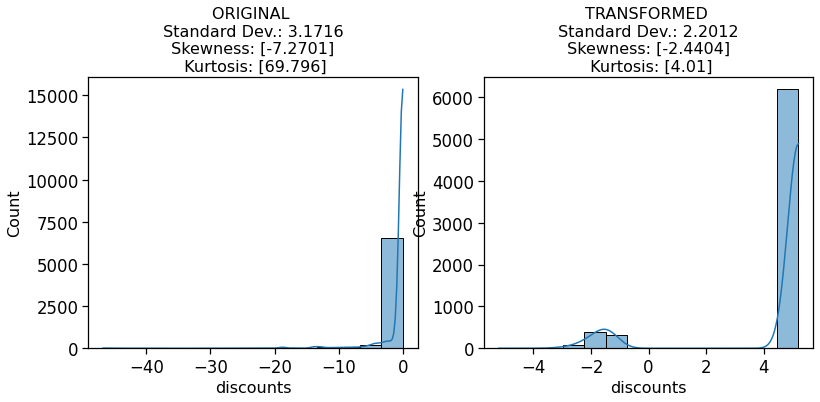

In [388]:
# Define function for comparing two plots
def compare_plot(feature, transformed_feature):
    plt.rcParams["figure.figsize"] = 13,5
    fig,ax = plt.subplots(1,2)

    stdDev = np.round(np.std(feature)[0],4) # for normal distribution, standard deviation is 1
    skewness = np.round(skew(feature),4) # for normal distribution, skewness = 0
    excess_kurtosis = np.round(kurtosis(feature),4) # for normal distribution, excess kurtosis = 0
    sns.histplot(feature, kde=True, ax=ax[0], legend=False)
    ax[0].set_xlabel(feature.columns[0])
    ax[0].set_title("ORIGINAL \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(stdDev, skewness, excess_kurtosis));

    transformed_stdDev = np.round(np.std(transformed_feature)[0],4)
    transformed_skewness = np.round(skew(transformed_feature),4)
    transformed_excess_kurtosis = np.round(kurtosis(transformed_feature),4)
    sns.histplot(transformed_feature, kde=True, ax=ax[1], legend=False)
    ax[1].set_xlabel(feature.columns[0])
    ax[1].set_title("TRANSFORMED \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(transformed_stdDev, transformed_skewness, transformed_excess_kurtosis));

from sklearn.preprocessing import QuantileTransformer

# Select feature
feature = ecom[["discounts"]] # in series

# Transformation
quantile = QuantileTransformer(output_distribution='normal', n_quantiles=len(feature)) # with gaussian output
quantile.fit(feature) # to avoid data leakage, only fit to training data
transformed_feature = quantile.transform(feature) # then perform transform on both training data and test data.
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

In [389]:
# Get statistical Test of data
colA = ecom_sub2[ecom_sub2['discounts'] >= 0][0:70]
print(colA.describe())
print("")

colB = ecom_sub2[ecom_sub2['discounts'] < 0][0:70]
colB['discounts'] = np.abs(colB['discounts'])
print(colB.describe())

difference_mean = round((colB-colA).mean(),5)
difference_std = round((colB-colA).std(),5)

       discounts
count       70.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0

       discounts
count  70.000000
mean    7.261571
std     8.014489
min     0.600000
25%     2.375000
50%     5.010000
75%     7.975000
max    42.830000


In [390]:
# By manual calculation
t = difference_mean/(difference_std/math.sqrt(25))

print("The test statistic is: ", round(t,3))

The test statistic is:  discounts           NaN
utm_campaign_name   NaN
dtype: float64


In [391]:
if 0: #commented because error 
  # By Python function
  (test_statistic, p_value) = stats.ttest_rel(colB, colA, nan_policy='omit')
  print("The test statistic is: ", round(test_statistic,3))
  print("The p-value is: ", round(p_value,3))

  if p_value < alpha_value:
      print("At",alpha_value, "level of significance, we reject null hypothesis.")
  else:
      print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

Independent Samples T-Test based on Student's

In [392]:
grpOne = ecom_sub.groupby("utm_campaign_name").get_group("shopify_cart_reminder")
colA = grpOne["discounts"]
print(colA.describe())
print("")

count    19.000000
mean     -2.210000
std       4.159323
min     -13.950000
25%      -2.340000
50%       0.000000
75%       0.000000
max       0.000000
Name: discounts, dtype: float64



In [393]:
grpTwo = ecom_sub.groupby("utm_campaign_name").get_group("11.11 SMS")
colB = grpTwo["discounts"]
print(colB.describe())

count    58.000000
mean     -4.868448
std       7.382184
min     -42.830000
25%      -5.605000
50%      -2.710000
75%       0.000000
max       0.000000
Name: discounts, dtype: float64


In [394]:
# By python function
(test_statistic, p_value) = stats.ttest_ind(colA, colB, equal_var = True, nan_policy='omit') # var.equal = TRUE mean two groups with equal variance, i.e. use Student's T test

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))
alpha_value = 0.05
if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  1.49
The p-value is:  0.14
At 0.05 level of significance, we failed to reject null hypothesis.


Independent Samples T-Test based on Welch's

In [395]:
(test_statistic, p_value) = stats.ttest_ind(colA, colB, equal_var =False, nan_policy='omit') # var.equal = False mean two groups with unequal variance, i.e. use Welch's T test
print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  1.954
The p-value is:  0.056
At 0.05 level of significance, we failed to reject null hypothesis.


Paired Samples T-test

In [396]:
# By Python function - Discounts are same or more
(test_statistic, p_value) = stats.ttest_rel(colB[0:19], colA[0:19], nan_policy='omit')
print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -1.102
The p-value is:  0.285
At 0.05 level of significance, we failed to reject null hypothesis.


Hypothesis Result - Column B (11.11 SMS) Has More Discounts

In [397]:
colA1 = ecom["discounts"]
print(colA1.describe())
print("")

colB1 = ecom["gross_profit"]
print(colB1.describe())

count    6982.000000
mean       -0.728115
std         3.171780
min       -46.740000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.000000
Name: discounts, dtype: float64

count    6982.000000
mean        0.822807
std         8.637701
min      -162.710000
25%         0.000000
50%         0.000000
75%         0.000000
max       187.780000
Name: gross_profit, dtype: float64


Z Test - Test the hypothesis that sample mean discount is __not equal__ to population mean discount

In [398]:
# Hypothesis test on non-probability based on sample
pop_mean  = 100 #reference mean
col = ecom['discounts'].dropna()
(test_statistic, p_value) = weightstats.ztest(col, value=pop_mean, alternative='two-sided')

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis.")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis.")

The test statistic is:  -2653.613
The p-value is:  0.0
At 0.05 level of significance, we reject null hypothesis.


H0 : Sample mean is equal to Reference Mean <br>
H1 : Sample mean is not equal to Reference Mean <br>

P value is 0.0, which is less than significant value i.e 0.05, We reject Null Hypothesis <br>

Conclusion: 
So Sample Mean is not equal to Reference Mean


Non-Parametric Test - Wilcoxon Signed Rank Test

In [399]:
(test_statistic, p_value) = stats.wilcoxon(colB1,colA1, alternative='two-sided')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Samples are likely not from the same distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Samples are likely from same the distribution.")

The test statistic is:  333734.0
The p-value is:  0.0 

At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Samples are likely not from the same distribution.


Pearson-Correlation (Parametrics)

In [400]:
if 0: #commented to skip err
  ecom_sub10 = ecom_sub[['11.11 SMS','gross_profit']]
  ecom_sub10.dropna(inplace=True)

  sns.pairplot(ecom_sub10)

In [401]:
if 0: #commented to skip err
  ecom_sub10.corr(method = 'pearson')

In [402]:
if 0: #commented to skip err
  ecom_sub10.corr(method = 'spearman')

In [403]:
test = ecom[['gross_profit',	'gross_margin', 'units_per_transaction']]
test.head()

,gross_profit,gross_margin,units_per_transaction
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0


In [404]:
test.corr(method = "spearman")

,gross_profit,gross_margin,units_per_transaction
gross_profit,1.000000,0.941973,0.489931
gross_margin,0.941973,1.000000,0.510550
units_per_transaction,0.489931,0.510550,1.000000


In [405]:
from scipy.stats import pearsonr

(Rho, p_value) = pearsonr(ecom['discounts'],ecom['gross_profit'])

print("The Pearson's correlation coefficient is: ", '{:.3f}'.format(Rho))
print("The p-value is:",'{:.3f}'.format(p_value))
    
if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The Pearson's correlation coefficient is:  0.078
The p-value is: 0.000
At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Monotonic association likely exist between these two variables.


In [406]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(ecom['discounts'],ecom['gross_profit'], nan_policy="omit")
#omit comes in when suppose missing values are present in data, you need to delete or remove otherwise
#it wouldn't calculate, since missing or na can't. If you didnt turn on the flag you will get an issue later

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

The correlation coefficient is:  -0.20
The p-value is: 0.00000
At 0.05 level of significance, we REJECT null hypothesis.
Conclusion: Monotonic association likely exist between these two variables.


# John's section

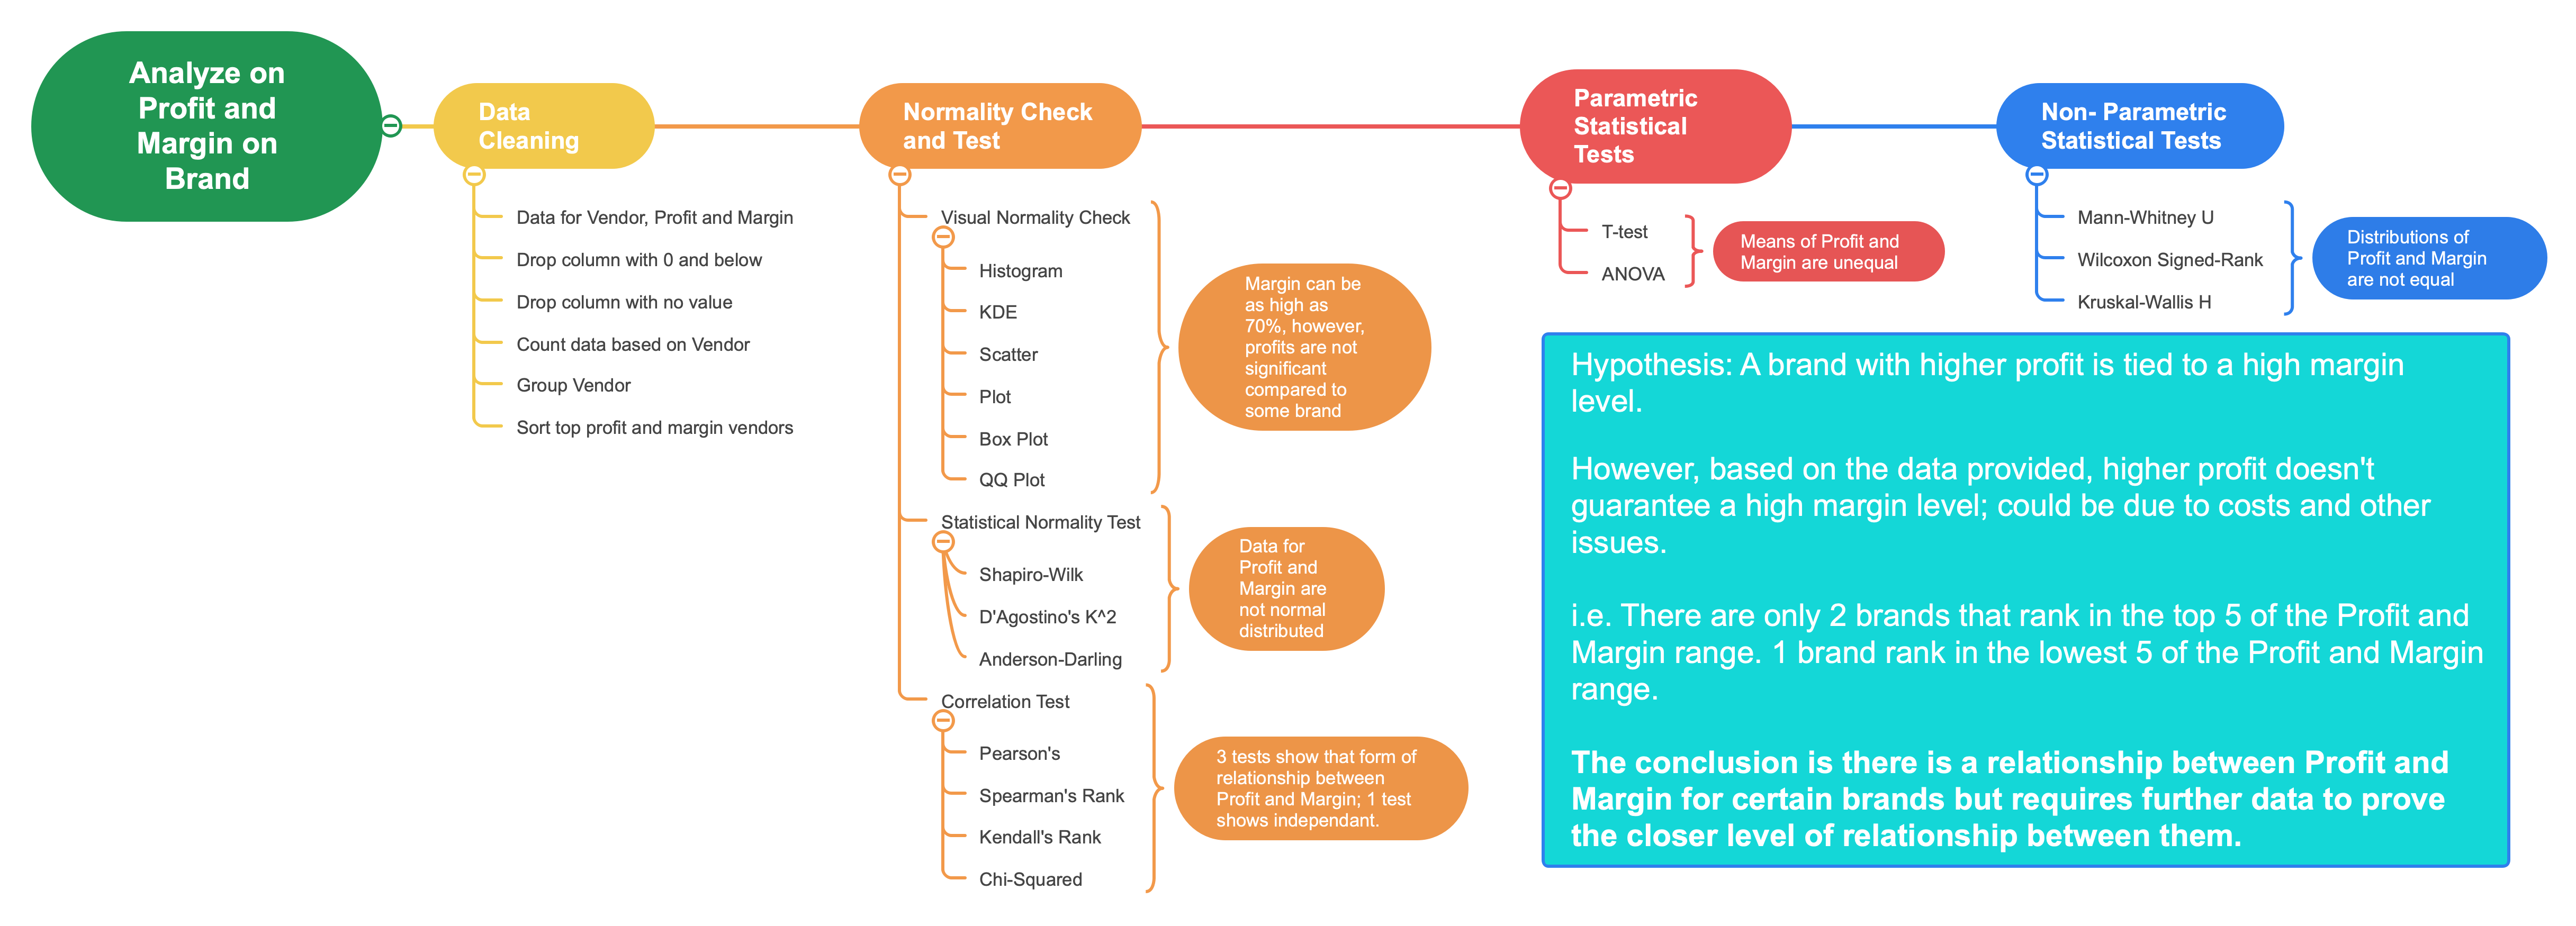

Section focus on
1. Product Vendor: Brands which tie to Highest gross profit and margin
2. Gross Profit: This leads to planning of optimising the brands we have, plus the planning for the leading brands (i.e. costs for stock, storage for them and etc.)

**Section 1: Data Cleaning**

In [407]:
import scipy.stats as stats # for t-test and ANOVA
import statsmodels.stats.weightstats as weightstats # for z-test (test of means)
import statsmodels.stats.proportion as proportion # for z-test (test of proportions)
import statsmodels.stats.multicomp as multi  #used for tukey-hsd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [408]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfjm = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfjm = pd.read_csv(csv_pathname)

display(dfjm.head())


read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


,hour,adjustment,cancelled,financial_status,fulfillment_status,order_id,order_name,purchase_option,sale_kind,sale_line_type,...,gross_profit,gross_margin,units_per_transaction,customers,pending_sales,net_quantity,ordered_item_quantity,average_units_ordered,returned_item_quantity,percent_of_sales_with_staff_help
0,9/1/2021 0:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
1,9/1/2021 1:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
2,9/1/2021 2:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
3,9/1/2021 3:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
4,9/1/2021 4:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0


In [409]:
# DataFrame for 3 focused columns
dfjm = pd.DataFrame(dfjm[["product_vendor", "gross_profit", "gross_margin" ]])
print('Current DataFrame')
print('=================')
display(dfjm)

# Get names of indexes for which column gross_profit has value 0 or below
indexNames = dfjm[ dfjm['gross_profit'] <= 0 ].index
# Delete these row indexes from dataFrame
dfjm.drop(indexNames , inplace=True)
# Drop gross_margin with 0 or below
indexNames = dfjm[ dfjm['gross_margin'] <= 0 ].index
dfjm.drop(indexNames , inplace=True)

# Remove row with null value
dfjm = dfjm.dropna(subset = ['product_vendor'])
dfjm = dfjm.dropna(subset = ['gross_profit'])
dfjm = dfjm.dropna(subset = ['gross_margin'])

print('')
print('======================================================================')

print(dfjm.info())

display(dfjm)
print('='*120)

# Get statistic of sample data - product_vendor (count, mean, variance, standard deviation). Round to the nearest whole number.
print('')
print('Latest DataFrame Statistic Information')
print('======================================')
print(dfjm.describe())
print('='*120)

pop_count = round(dfjm.product_vendor.count(),5)

print ("Sample Count for Product Vendor = ", pop_count)
print ("Unique count for Product Vendor = ", len(dfjm["product_vendor"].unique()))
print('='*120)

Current DataFrame


,product_vendor,gross_profit,gross_margin
0,NaN,0.0,0.0
1,NaN,0.0,0.0
2,NaN,0.0,0.0
3,NaN,0.0,0.0
4,NaN,0.0,0.0
...,...,...,...
6977,NaN,0.0,0.0
6978,NaN,0.0,0.0
6979,Les-Merveilleuses-LADUREE,0.0,0.0
6980,NaN,0.0,0.0



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407 entries, 17 to 6968
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_vendor  1407 non-null   object 
 1   gross_profit    1407 non-null   float64
 2   gross_margin    1407 non-null   float64
dtypes: float64(2), object(1)
memory usage: 44.0+ KB
None


,product_vendor,gross_profit,gross_margin
17,FANCL,6.09,0.17657
18,DHC,5.86,0.63351
20,ETVOS,0.81,0.17685
22,KOBAYASHI,4.03,0.22819
139,PeLican,3.71,0.44591
...,...,...,...
6942,SHISEIDO-ELIXIR,13.26,0.21529
6946,IPSA,4.45,0.07949
6950,KAI,7.30,0.43870
6952,CANMAKE,4.13,0.31793



Latest DataFrame Statistic Information
       gross_profit  gross_margin
count   1407.000000   1407.000000
mean       8.266496      0.249563
std       12.280427      0.157361
min        0.080000      0.000730
25%        3.300000      0.134320
50%        5.640000      0.223730
75%        9.480000      0.335985
max      187.780000      0.724350
Sample Count for Product Vendor =  1407
Unique count for Product Vendor =  178


In [410]:
# Group by Vendor and Gross Profit
grouped2 = dfjm.groupby(['product_vendor']).sum()
print (grouped2)

                 gross_profit  gross_margin
product_vendor                             
ALBION                  81.61       1.14359
ALLIE                    2.90       0.10736
AMPLEUR                 22.05       0.41895
ASHIURA RAN RUN         11.15       1.20548
ASHIURA-RAN-RUN          3.55       0.39576
...                       ...           ...
mama-kids               95.14       1.72295
the-ginza               26.86       0.09683
white conc              52.68       2.62694
white-conc               3.98       0.26801
富山药品                     7.29       0.20634

[178 rows x 2 columns]


In [411]:
# Sort the Highest Profit of Vendor (Top 5)
print(grouped2.sort_values('gross_profit', ascending=False))
# Sort by Highest Margin
print(grouped2.sort_values('gross_margin', ascending=False))

                gross_profit  gross_margin
product_vendor                            
POLA                 1684.08      19.36155
FANCL                1447.65      38.07647
SVELTY                432.86       9.95248
Shinya-Koso           328.94       3.21650
The Ginza             314.09       0.95926
...                      ...           ...
Nitto tea               1.55       0.31568
SHISEIDO-FINO           1.24       0.11151
Mandom                  1.20       0.16563
Cow Bouncia             1.01       0.22052
ORBIS                   0.19       0.00550

[178 rows x 2 columns]
                gross_profit  gross_margin
product_vendor                            
FANCL                1447.65      38.07647
POLA                 1684.08      19.36155
DHC                   191.86      14.53281
SHISEIDO              203.59      13.68382
LION                  106.57      11.42221
...                      ...           ...
the-ginza              26.86       0.09683
PAUL & JOE              3.75  

**Section 2 : Normality Tests** 

---

In [412]:
# If Data Is Gaussian:
#	Use Parametric Statistical Methods
# Else:
#	Use Nonparametric Statistical Methods

**Visual Normality Check**

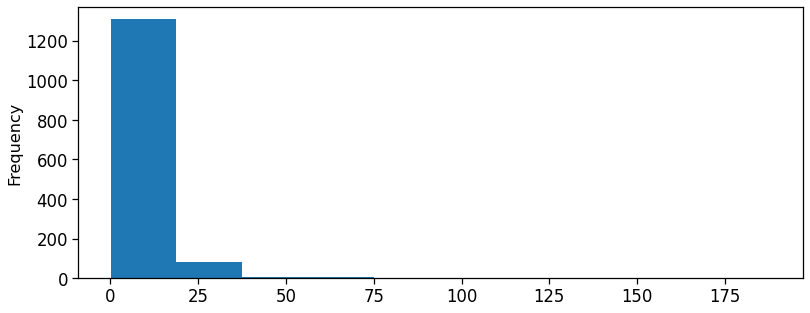

In [413]:
# Histogram Plot Profit
from matplotlib import pyplot
ax = dfjm['gross_profit'].plot.hist()
pyplot.show()

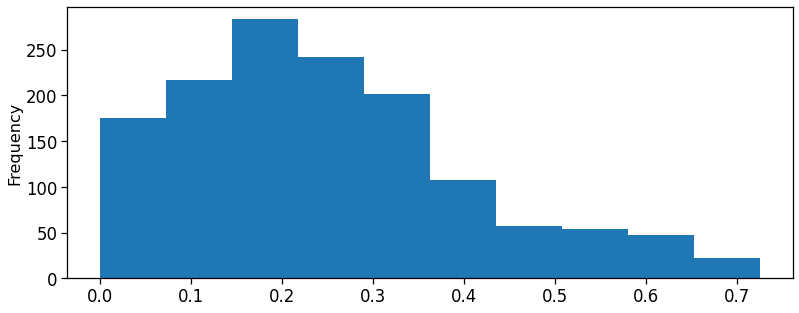

In [414]:
# Histogram Plot Margin
from matplotlib import pyplot
ax = dfjm['gross_margin'].plot.hist()
pyplot.show()

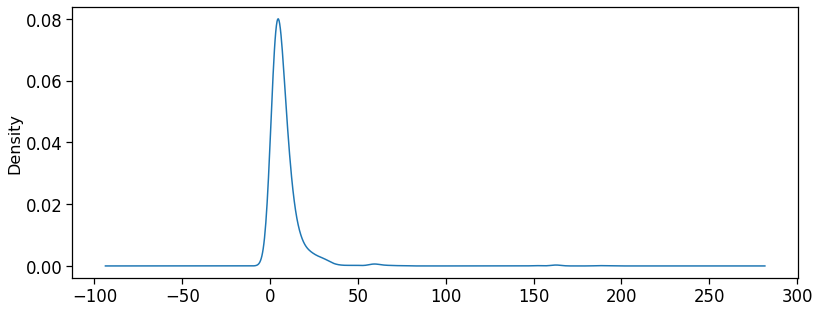

In [415]:
# KDE Plot Profit
ax = dfjm['gross_profit'].plot.kde()
pyplot.show()

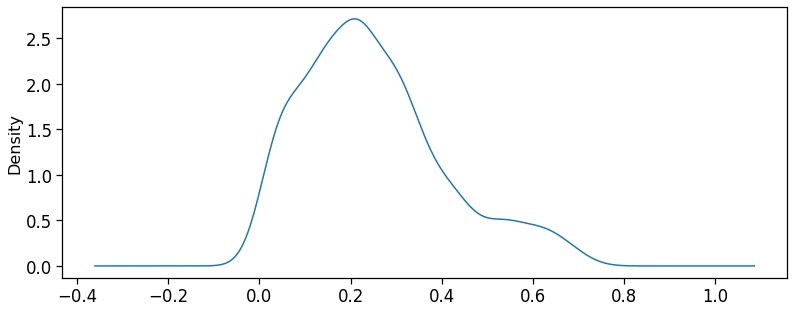

In [416]:
# KDE Plot Margin
ax = dfjm['gross_margin'].plot.kde()
pyplot.show()

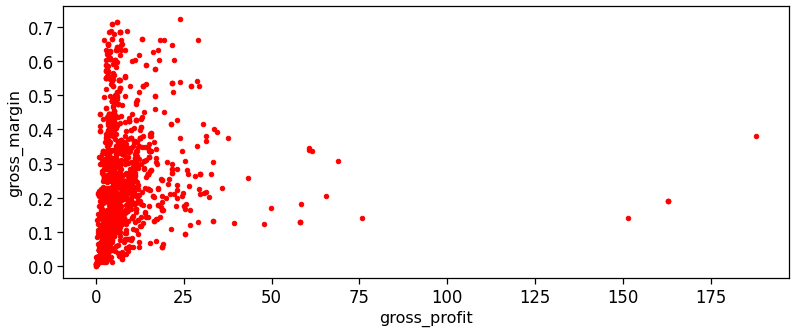

In [417]:
# Scatter Plot
ax = dfjm.plot.scatter(x='gross_profit',y='gross_margin',c='red')
pyplot.show()

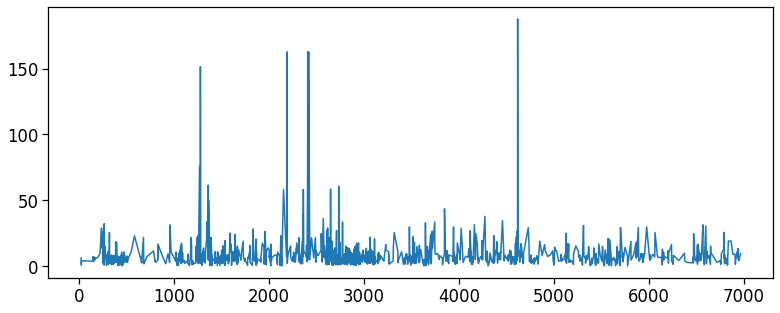

In [418]:
# Plot for Profit
dfjm['gross_profit'].plot()

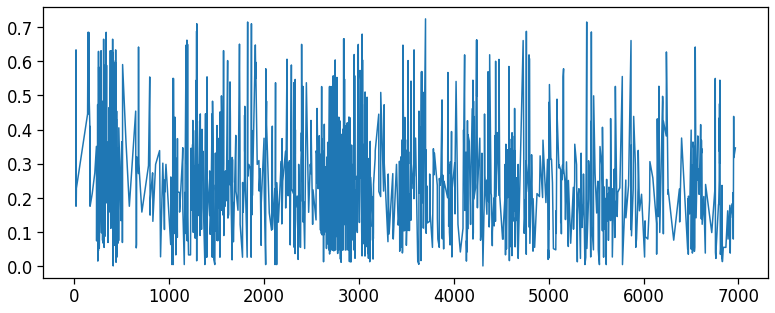

In [419]:
# Plot for Margin
dfjm['gross_margin'].plot()

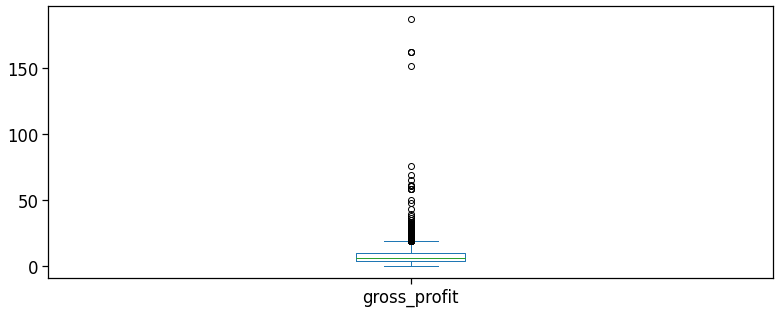

In [420]:
# Box plot for distribution for gross profit
dfjm["gross_profit"].plot.box()

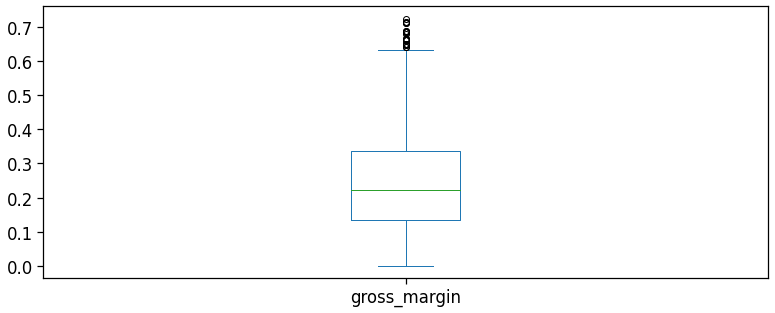

In [421]:
# Box plot for distribution for gross margin
dfjm["gross_margin"].plot.box()

**Quantile-Quantile Plot**

---


This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution.

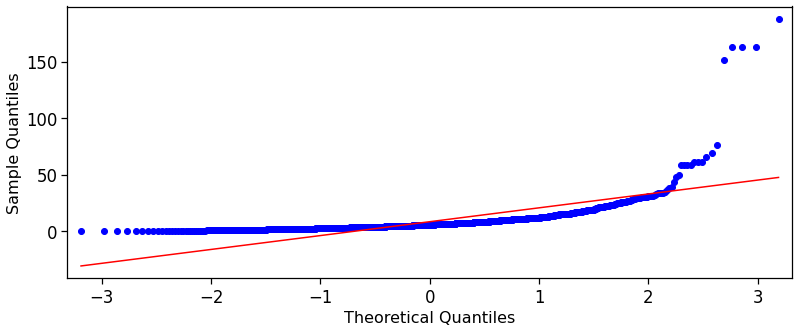

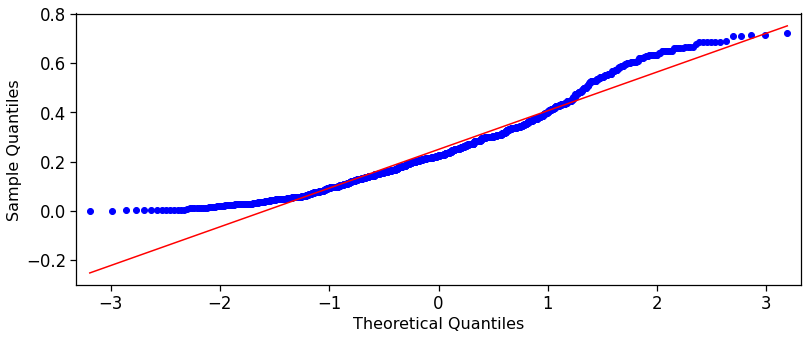

In [422]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
sm.qqplot(dfjm['gross_profit'], line='s')
sm.qqplot(dfjm['gross_margin'], line='s')
plt.show()

**Conclusion** 

---


A Gaussian-like shape to the data of Gross Margin but not Gross Profit.

**Statistical Normality Tests** 

---



**Shapiro-Wilk Test**

---

Tests whether a data sample has a Gaussian distribution.



In [423]:
from scipy.stats import shapiro
# Normality test for Gross Profit
data = dfjm['gross_profit']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.424, p=0.000
Probably not Gaussian


In [424]:
# Normality test for Gross Margin
data = dfjm['gross_margin']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.951, p=0.000
Probably not Gaussian


**Interpretation** 

---

H1: the sample does not have a Gaussian distribution.

**D’Agostino’s K^2 Test** 

---

The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

In [425]:
from scipy.stats import normaltest
# Normality test for Gross Profit
data = dfjm['gross_profit']
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=2048.104, p=0.000
Sample does not look Gaussian (reject H0)


In [426]:
# Normality test for Gross Margin
data = dfjm['gross_margin']
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=111.903, p=0.000
Sample does not look Gaussian (reject H0)


**Conclusion** 

---

H1: the sample does not have a Gaussian distribution.



**Anderson-Darling Test** 

---

Anderson-Darling Test is a statistical test that can be used to evaluate whether a data sample comes from one of among many known data samples.

In [427]:
from scipy.stats import anderson
data = dfjm["gross_profit"]
# Normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 176.358
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.785, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.089, data does not look normal (reject H0)


In [428]:
data = dfjm["gross_margin"]
# Normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 16.572
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.785, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.089, data does not look normal (reject H0)


**Conclusion** 

---

H1: the sample does not have a Gaussian distribution.



**Correlation Tests** 

---

This section lists statistical tests that you can use to check if two samples are related.



**Pearson’s Correlation Coefficient** 

---

Tests whether two samples have a linear relationship.



In [429]:
from scipy.stats import pearsonr
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.089, p=0.001
Probably dependent


**Conclusion** 

---

H1: there is a dependency between the samples.


**Spearman’s Rank Correlation** 

---

Tests whether two samples have a monotonic relationship.




In [430]:
from scipy.stats import spearmanr
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.332, p=0.000
Probably dependent


**Conclusion** 

---
H1: there is a dependency between the samples.



**Kendall’s Rank Correlation** 

---

Tests whether two samples have a monotonic relationship.




In [431]:
from scipy.stats import kendalltau
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.228, p=0.000
Probably dependent


**Conclusion** 

---

H1: there is a dependency between the samples.



**Chi-Squared Test** 

---

Tests whether two categorical variables are related or independent.




In [432]:
from scipy.stats import chi2_contingency
table = dfjm['gross_profit'],dfjm['gross_margin']
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')


stat=383.456, p=1.000
Probably independent


**Interpretation** 

---

H0: the two samples are independent.


**Section 3 : Parametric Statistical Hypothesis Tests** 

---



**T-test** 

---

Tests whether the means of two independent samples are significantly different.




In [433]:
from scipy.stats import ttest_ind
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=24.485, p=0.000
Probably different distributions


**Interpretation** 

---

H1: one or more of the means of the samples are unequal.


**Analysis of Variance Test (ANOVA)** 

---

Tests whether the means of two or more independent samples are significantly different.



In [434]:
from scipy.stats import f_oneway
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = f_oneway(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=599.532, p=0.000
Probably different distributions


**Interpretation** 

---

H1: the means of the samples are unequal.


**Section 4 : Nonparametric Statistical Hypothesis Tests** 

---



**Mann-Whitney U Test** 

---

Tests whether the distributions of two independent samples are equal or not.


In [435]:
from scipy.stats import mannwhitneyu
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=15125.000, p=0.000
Probably different distributions


**Interpretation** 

---

H1: the distributions of both samples are not equal.


**Wilcoxon Signed-Rank Test** 

---

Tests whether the distributions of two paired samples are equal or not.



In [436]:
from scipy.stats import wilcoxon
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = wilcoxon(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=0.000, p=0.000
Probably different distributions


**Interpretation** 

---

H1: the distributions of both samples are not equal.


**Kruskal-Wallis H Test** 

---

Tests whether the distributions of two or more independent samples are equal or not.

In [437]:
from scipy.stats import kruskal
data1 = dfjm["gross_profit"]
data2 = dfjm["gross_margin"]
stat, p = kruskal(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


stat=2045.769, p=0.000
Probably different distributions


**Interpretation** 

---

H1: the distributions of one or more samples are not equal.

# Common section to check errors


In [440]:
# catch error message
!grep -crni "Error" "./Team_5_Project_(JH)_v1_1.ipynb"

1


In [441]:
print(f"END time {str(dt.datetime.now(pytz.timezone('Singapore'))).split('.')[0]}")

END time 2022-05-25 20:21:18
